In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from time import sleep
import os 
import glob
import json
from pandas.plotting import scatter_matrix as sm
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
from chime_frb_constants import K_DM, FREQ_BOTTOM_MHZ, FREQ_TOP_MHZ
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 24
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [2]:
def get_color_vals(time_res, cmap='viridis'):
    
    n_values = np.arange(9)  # n ranges from 0 to 8
    time_res_values = 2 ** n_values * 2.56 * 1e-6
    
    cmap_i = cmap
    print("Getting the normalizations ########")

    norm = mpl.colors.SymLogNorm(vmin=np.min(time_res_values), vmax=np.max(time_res_values), clip=False, base=2, linthresh=1e-6)

    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_i)

    print("\nGetting the colors ######")

    width_color = []

    for t in time_res:
        width_color.append(mapper.to_rgba(t))
        
    return width_color, mapper

In [3]:
cosmo.luminosity_distance(2)

<Quantity 15924.56665166 Mpc>

In [4]:
dm_z_line = np.linspace(0.2, 1.8, 9)
dms_z = 855 * dm_z_line
print(dms_z)

[ 171.  342.  513.  684.  855. 1026. 1197. 1368. 1539.]


In [5]:
def get_energy(DM_eg, fluence, bw):
    
    z = DM_eg / 855 #https://arxiv.org/pdf/2212.03972.pdf eqn 12
    lum_dist = cosmo.luminosity_distance(z) * 3.086e+24 #### Convert to cms
    fluence_s = fluence/1e3
    bw_hz = bw * 1e6
    
    e  = 4 * np.pi * 1e-23 * (lum_dist)**2 * fluence_s * bw_hz ## https://iopscience.iop.org/article/10.3847/2041-8213/ac2a3a/pdf eqn 3 in ergs
    
    return e

In [6]:
#### Load catalog data ####

cat_file = '/arc/home/ksand/Basecat_morph/fitburst_runs/Run3_plots/catalog1.json'
f = open(cat_file)
data_cat = json.load(f)

catalog1_events = []

for i in range(len(data_cat)):
    catalog1_events.append(int(data_cat[i]['event_number']))
    
catalog1_events = np.array(catalog1_events)
df_cat = pd.DataFrame(data_cat)

####### Manipulating to add minimum width and bandwidth ###########

df_cat['pulse_width_ms'] = df_cat['pulse_width_ms'].apply(np.array)
w = df_cat['pulse_width_ms'].to_numpy()

for i in range(len(w)):
    for j in range(len(w[i])):
        try:
            w[i][j] = float(w[i][j].split('<')[-1])
        except:
            w[i][j] = float(w[i][j])

df_cat['pulse_width_ms_error'] = df_cat['pulse_width_ms_error'].apply(np.array)
w_err = df_cat['pulse_width_ms_error'].to_numpy()

df_cat['bandwidth_high'] = df_cat['bandwidth_high'].apply(np.array)
bw_high = df_cat['bandwidth_high'].to_numpy()

df_cat['bandwidth_low'] = df_cat['bandwidth_low'].apply(np.array)
bw_low = df_cat['bandwidth_low'].to_numpy()

width_min_int = []
width_min_int_err = []
bandwidth = []

bw_highest = []
bw_lowest = []

for i in range(len(w)):
    j = np.argmin(w[i])
    k = np.argmax(bw_high[i])
    l = np.argmin(bw_low[i])
    bandwidth.append(bw_high[i][k] - bw_low[i][l])
    
    bw_highest.append(bw_high[i][k])
    bw_lowest.append(bw_low[i][l])
    
    width_min_int.append(w[i][j])
    width_min_int_err.append(w_err[i][j])
    
df_cat['pulse_width_min'] = width_min_int
df_cat['pulse_width_min_err'] = width_min_int_err
df_cat['bandwidth'] = bandwidth

df_cat['hi'] = bw_highest
df_cat['lo'] = bw_lowest


###### Manipulating to get scattering measurements #####

sc_int = df_cat['scattering_time_ms'].to_numpy()
sc_int_err = df_cat['scattering_time_ms_error'].to_numpy()
sc_int_final = []
sc_limit = []
                                            
for i in range(len(sc_int)):
    if sc_int_err[i] == 0:
        x = sc_int[i].split('<')[-1]
        sc_int_final.append(float(x))
        sc_limit.append('two')
    else:
        sc_int_final.append(float(sc_int[i]))
        sc_limit.append('three')
                                             
df_cat['scattering_time_ms'] = sc_int_final
df_cat['scattering_limit'] = sc_limit

In [7]:
data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json') #### Loading basecat information ####
data_basecat['Ratio(w/s)'] = round(data_basecat['Min_width(s)']/data_basecat['Scattering(s)'],2)
data_basecat['DM_eg'] = data_basecat['DM'] - data_basecat['MW_DM']
data_basecat['RM_eg'] = data_basecat['RM'] - data_basecat['MW_RM']
data_basecat['RM_eg_err'] = np.sqrt(data_basecat['RM_err']**2 + data_basecat['MW_RM_err']**2)
# data_basecat['Sc_eg'] = data_basecat['Scattering(s)'] #- data_basecat['MW_scat']


### arranging scattering limits less than expected from galaxy #####

sc_all = data_basecat['Scattering(s)'].to_numpy()
ev = data_basecat['Event'].to_numpy()
sc_gal = data_basecat['MW_scat'].to_numpy()
sc_eg_mod = np.zeros(len(ev))


for i in range(len(sc_all)):
    if sc_gal[i] > sc_all[i]:
        sc_eg_mod[i] = sc_gal[i]
    else:
        sc_eg_mod[i] = sc_all[i]
    # print(sc_eg[i], sc_eg_mod[i])

data_basecat['Sc_eg'] = sc_eg_mod.tolist()

data_basecat['Energy'] = get_energy(data_basecat['DM_eg'], data_basecat['Fluence(Jy_ms)'], data_basecat['Bandwidth'])
display(data_basecat)

# data_only_scat = data_basecat[(data_basecat['Fit_type'] == 'Scint') | (data_basecat['Fit_type'] == 'Scat')]

# data_no_scint = data_basecat[(data_basecat['Fit_type'] != 'Scint')]

data_final_basecat = data_basecat[(data_basecat['Min_width(s)'] > 5e-6)]
# data_final_basecat = data_final_basecat[(data_final_basecat['Min_width_err(s)'] < data_final_basecat['Min_width(s)'])]
# data_final_basecat = data_final_basecat.dropna()
print(len(data_final_basecat))

data_final_basecat_no_profile = data_final_basecat[(data_final_basecat['Fit_type'] != 'Profile')]
data_final_basecat_only_profile = data_final_basecat[(data_final_basecat['Fit_type'] == 'Profile')]

#print(len(data_final_basecat_no_profile))

data_only_scat_final = data_final_basecat[(data_final_basecat['Fit_type'] == 'Scint') | (data_final_basecat['Fit_type'] == 'Scat')]
data_no_scat_final = data_final_basecat[(data_final_basecat['Fit_type'] == 'Noscat')]

#display(data_no_scat_final)

,Event,Fit_type,TNS_name,Time_res(s),DM,DM_err,Flux(Jy),Flux_err(Jy),Fluence(Jy_ms),Fluence_err(Jy_ms),RM,RM_err,Pol_frac,Pol_frac_err,Pol_frac_upper,Sig_RM_limit,Widths(s),Widths_err(s),Widths_err_sim(s),Min_width(s),Min_width_err(s),Min_width_err_sim(s),Max_width(s),Max_width_err(s),Max_width_err_sim(s),Scattering(s),Scattering_err(s),Scattering_err_sim(s),Num_comps,Boxcar_width(s),Rel_arrival_time(s),Fitburst_chi_sqr,Fit_snr,Bandwidth_low,Bandwidth_high,Bandwidth,Top_avail_freq,Sim_scat_err_percent,Sim_width_err_percent,Sim_fit_snr_mean,MW_DM,MW_RM,MW_RM_err,MW_scat,Repeater,Ratio(w/s),DM_eg,RM_eg,RM_eg_err,Sc_eg,Energy
0,22154974,Scint,FRB20181209A,0.000003,328.592265,0.009821,16.932807,1.702109,11.065309,1.138121,-110.3,0.051,0.90,0.011,-1.000,0.918087,[4.768360137867595e-05],[1.5256020457061478e-06],[9.187944668779769e-07],0.000048,1.525602e-06,9.187945e-07,0.000048,1.525602e-06,9.187945e-07,0.000114,1.104592e-06,0.000004,1,0.000576,[0.0],0.934452,146.444647,400.195312,800.195312,400.000000,800.195312,3.653516,1.926856,139.646670,95.493259,-21,8,3.583425e-06,False,0.42,233.099006,-89.3,8.000163,0.000114,1.092291e+40
1,22310619,Scint,FRB20181213A,0.000020,678.690379,0.011710,6.337638,0.653551,8.176461,0.885456,10.2,0.092,1.09,0.033,-1.000,0.000000,"[7.810057339618419e-05, 4.8295026501822585e-05...","[4.097062896981601e-06, 5.874072296003162e-06,...","[1.557235476661156e-05, 9.629472018524685e-06,...",0.000048,5.874072e-06,9.629472e-06,0.000078,4.097063e-06,1.557235e-05,0.000167,2.438361e-06,0.000046,3,0.002683,"[0.0, 0.000568553420463, 0.001926329474445]",0.963051,91.416743,400.195312,800.195312,400.000000,800.195312,27.266337,19.938848,90.833009,78.540010,-12,6,1.845107e-06,False,0.29,600.150369,22.2,6.000705,0.000167,7.575485e+40
2,22457855,Scat,FRB20181214C,0.000082,632.827111,0.006636,4.503233,0.481316,15.218117,1.587706,23.6,0.206,0.60,0.028,-1.000,2.021535,"[0.00038195614126100005, 6.706078347096188e-05]","[1.557235476661156e-05, 9.629472018524685e-06,...","[3.249944663114827e-05, 5.705991128356625e-06]",0.000067,5.705991e-06,5.705991e-06,0.000382,3.249945e-05,3.249945e-05,0.001599,6.619611e-05,0.000199,2,0.006881,"[0.0, 0.0011205827035090001]",0.985750,57.538622,400.195312,800.195312,400.000000,800.195312,12.448445,8.508685,69.091103,63.337543,6,2,7.801473e-07,False,0.04,569.489568,17.6,2.010581,0.001599,1.240879e+41
3,22574084,Profile,FRB20181215B,0.000003,494.044029,0.005933,14.328002,1.436619,12.543438,1.262924,8.6,0.022,1.02,0.009,-1.000,0.000000,"[1.3837813459083203e-05, 4.9612728404805506e-0...","[2.058903718113965e-07, 8.030663904185624e-07,...",[0.0],0.000014,2.058904e-07,0.000000e+00,0.000196,6.143760e-06,0.000000e+00,0.000006,1.782339e-07,0.000000,4,0.000635,"[0.0, 4.667052584782206e-05, 0.000340633538117...",0.000000,0.000000,400.195312,800.195312,400.000000,800.195312,0.000000,0.000000,0.000000,70.436366,14,4,1.357931e-06,False,2.33,423.607663,-5.4,4.000060,0.000006,5.007606e+40
4,23070533,Scint,FRB20181219C,0.000328,647.762798,0.041208,3.867239,0.435312,17.462872,1.838531,9999.0,0.000,-1.00,0.000,0.210,-1.000000,[0.000614494089507],[2.6744827917733282e-05],[3.0385399955067662e-05],0.000614,2.674483e-05,3.038540e-05,0.000614,2.674483e-05,3.038540e-05,0.001052,2.286320e-05,0.000112,1,0.010158,[0.0],0.908123,61.551006,400.195312,800.195312,400.000000,800.195312,10.643646,4.944783,64.108865,66.391929,9999,0,9.312322e-07,False,0.58,581.370868,0.0,0.000000,0.001052,1.497312e+41
5,23232723,Scint,FRB20181220A,0.000020,209.516784,0.008116,0.000000,0.000000,0.000000,0.000000,97.5,0.379,0.43,0.024,-1.000,2.598415,[7.359974807495678e-05],[4.452494125703943e-06],[1.819452012719509e-06],0.000074,4.452494e-06,1.819452e-06,0.000074,4.452494e-06,1.819452e-06,0.000213,3.824171e-06,0.000010,1,0.001331,[0.0],0.940617,77.567730,400.195312,800.195312,400.000000,800.195312,4.495174,2.472090,79.132844,148.552562,-23,11,1.723378e-05,False,0.35,60.964222,120.5,11.006527,0.000213,0.000000e+00
6,23438043,Scint,FRB20181221A,0.0001

137


In [63]:
sc_all = data_basecat['Scattering(s)'].to_numpy()
ev = data_basecat['Event'].to_numpy()
sc_gal = data_basecat['MW_scat'].to_numpy()
fit_type = data_basecat['Fit_type'].to_numpy()

for i in range(len(ev)):
    # print(ev[i], sc_all[i], sc_gal[i], sc_all[i]/sc_gal[i], fit_type[i])
    
    if (sc_all[i]/sc_gal[i]) < 3:
        print(ev[i], fit_type[i], sc_all[i])

print(np.max(data_basecat['MW_scat']))

25281508 Noscat 1.4587967783511161e-05
25660576 Scint 0.000178822319295
39069820 Scint 0.00024962602098800005
41252817 Scint 3.049472519010848e-05
41464641 Profile 9.687462655918703e-05
0.000168351752999


In [20]:
events = data_final_basecat['Event'].to_numpy().astype(str)

df_new_cat = df_cat[df_cat['event_number'].isin(events)] 

df_new_cat = df_new_cat.sort_values(by = 'event_number')


events_int = df_new_cat['event_number'].to_numpy().astype(int)
dms_int = df_new_cat['fitburst_dm'].to_numpy().astype(float)
dms_int_err = df_new_cat['fitburst_dm_error'].to_numpy().astype(float)
scats_int = df_new_cat['scattering_time_ms'].to_numpy().astype(float)
scats_int_err = df_new_cat['scattering_time_ms_error'].to_numpy().astype(float)
widths_min_int = df_new_cat['pulse_width_min'].to_numpy().astype(float)
widths_min_int_err = df_new_cat['pulse_width_min_err'].to_numpy().astype(float)
bws_int = df_new_cat['bandwidth'].to_numpy().astype(float)
ncomps_int = df_new_cat['num_sub_bursts'].to_numpy().astype(int)

In [21]:
##### Loading values ######

scats = data_only_scat_final['Scattering(s)'].to_numpy()  ### Have to remove milky way component #####
scat_errs = data_only_scat_final['Scattering_err_sim(s)'].to_numpy()

min_widths = data_only_scat_final['Min_width(s)'].to_numpy() 
min_width_errs = data_only_scat_final['Min_width_err(s)'].to_numpy()

dms = data_only_scat_final['DM'].to_numpy() ### Have to remove milky way component #####
dm_errs = data_only_scat_final['DM_err'].to_numpy()

rms = data_only_scat_final['RM'].to_numpy() ### Have to remove milky way component #####
rm_errs = data_only_scat_final['RM_err'].to_numpy()

fluxes = data_only_scat_final['Flux(Jy)'].to_numpy()
flux_errs = data_only_scat_final['Flux_err(Jy)'].to_numpy()

fluences = data_only_scat_final['Fluence(Jy_ms)'].to_numpy()
fluence_errs = data_only_scat_final['Fluence_err(Jy_ms)'].to_numpy()

bandwidths = data_only_scat_final['Bandwidth'].to_numpy()
bandwidth_errs = np.zeros(len(bandwidths))

pol_fracs = data_only_scat_final['Pol_frac'].to_numpy()
pol_frac_errs = data_only_scat_final['Pol_frac_err'].to_numpy()

In [11]:
# for i in range(len(rms)):
#     if rms[i] < 9999:
#         print(rms[i], pol_fracs[i])
#     else:
#         print("No rm measurement events", rms[i], pol_fracs[i])

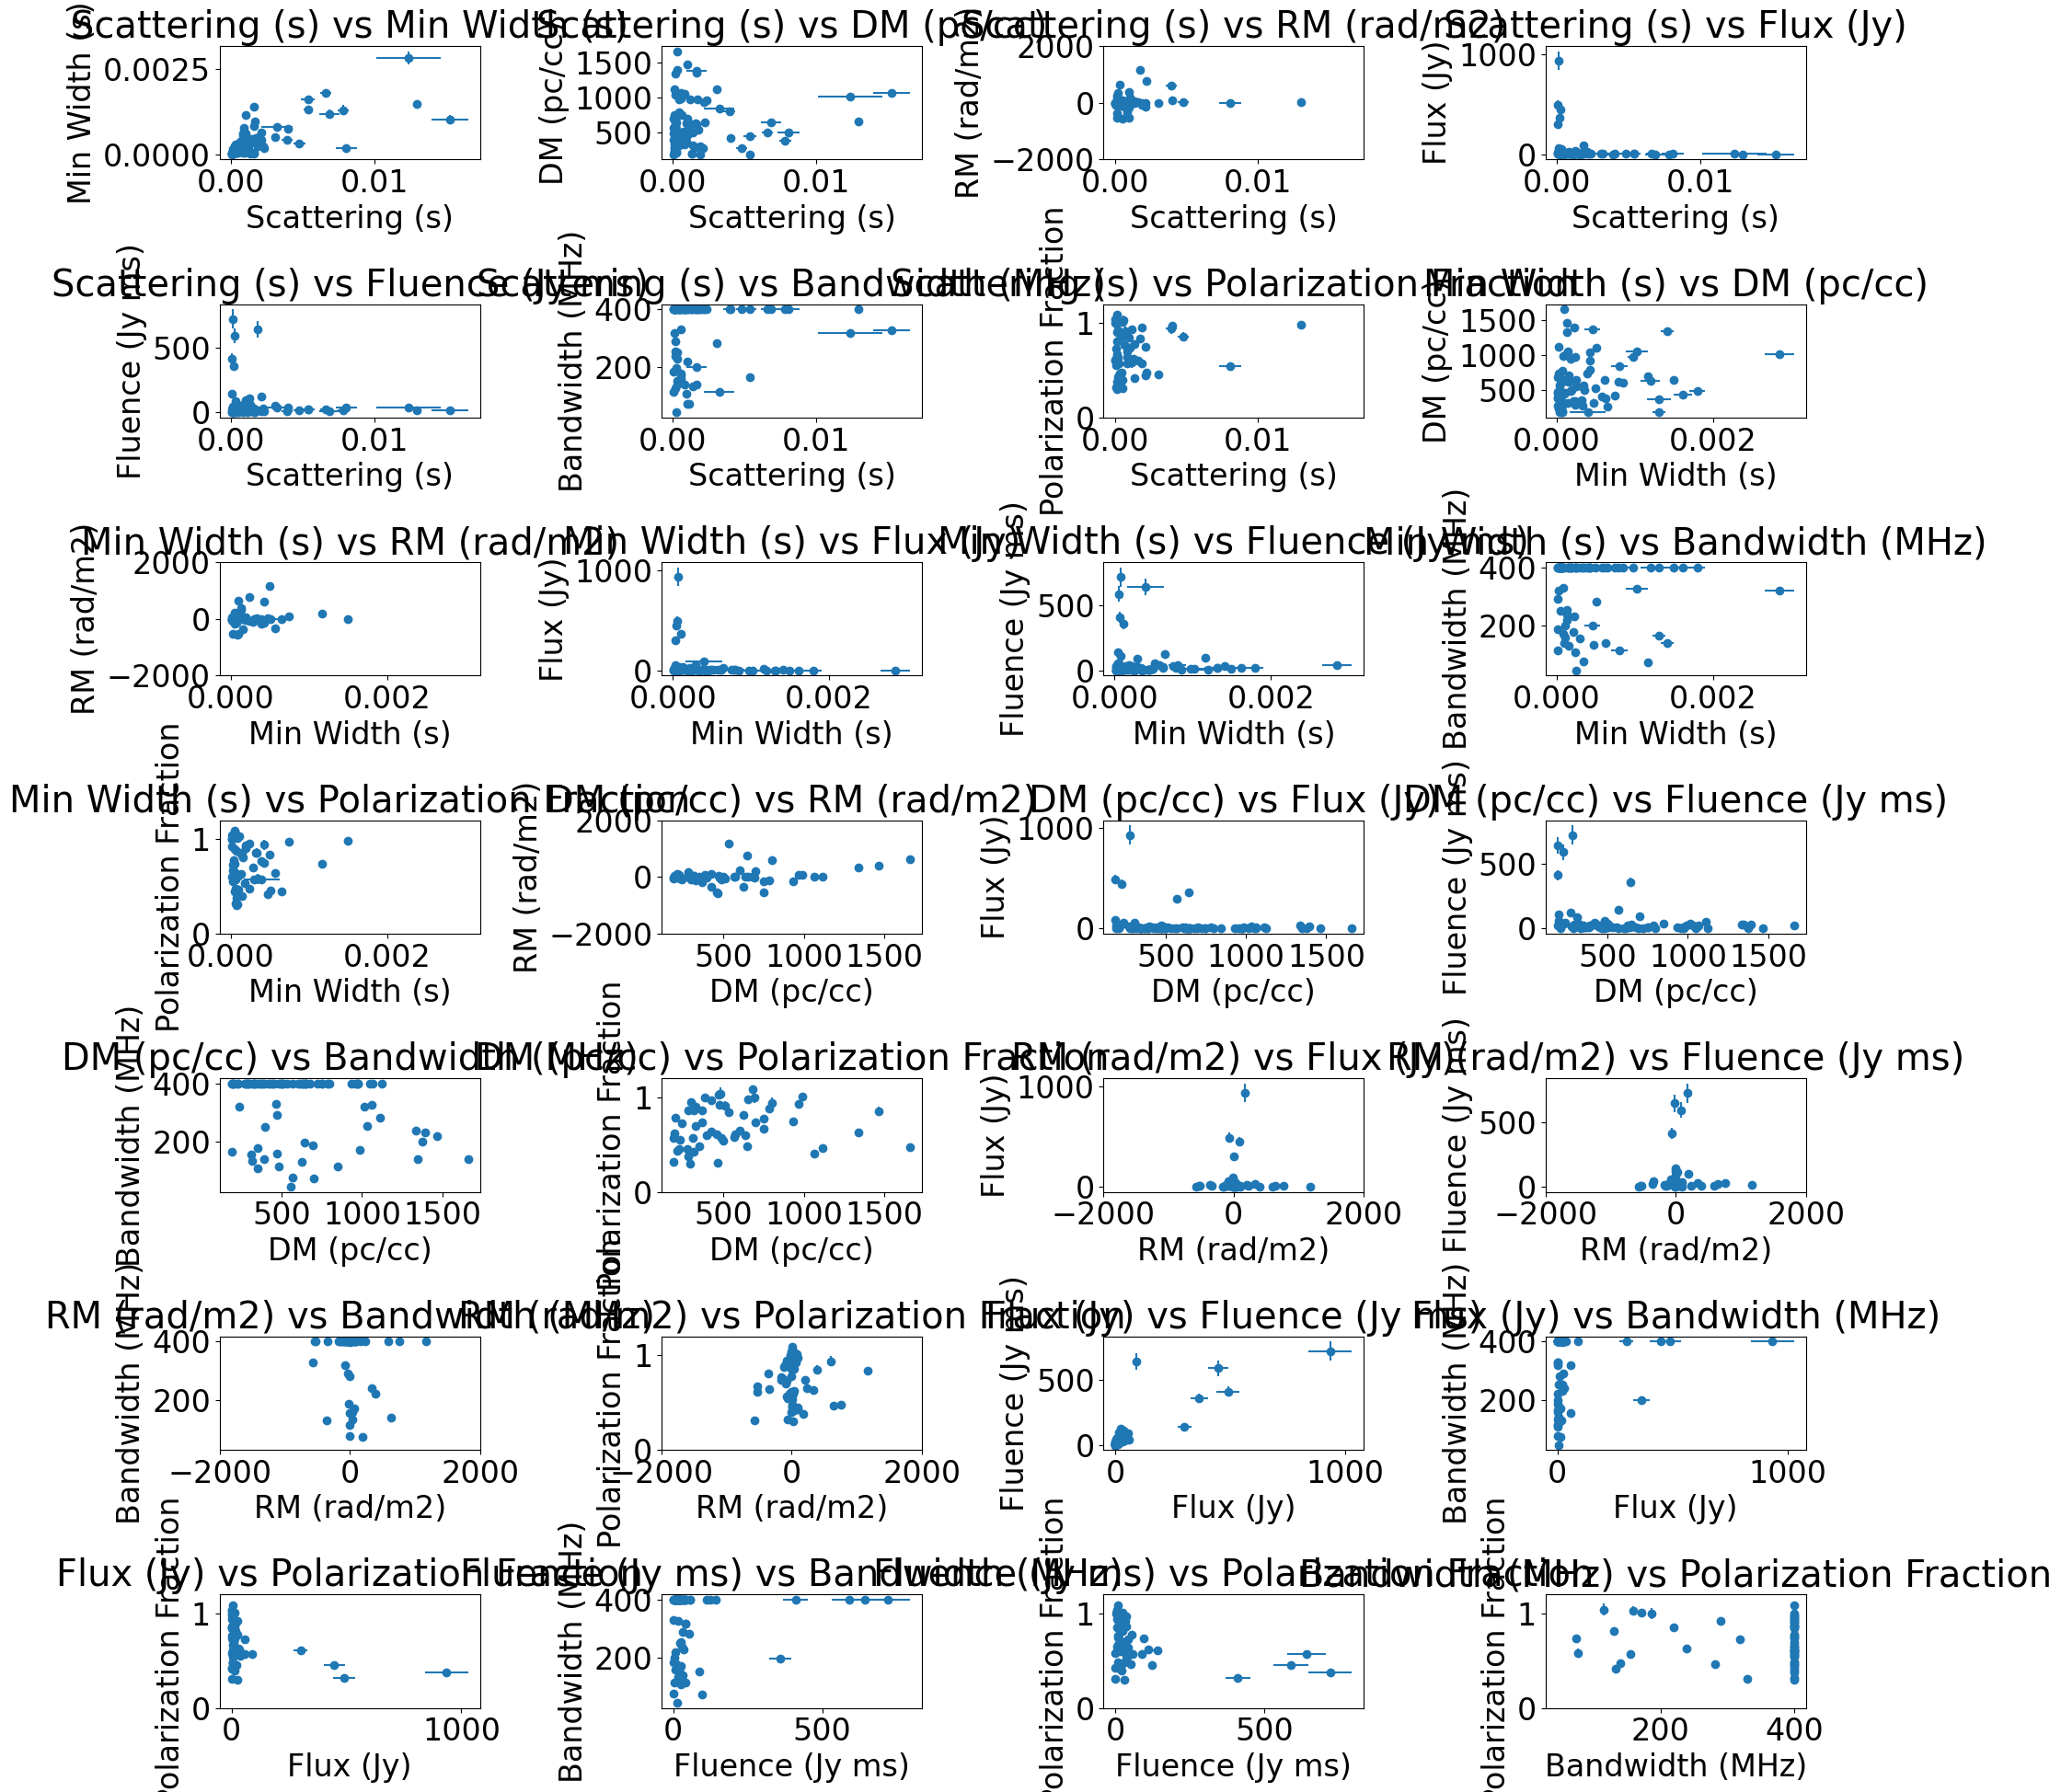

In [22]:

rm_lim = (-2000, 2000)
pol_frac_lim = (0, 1.2)


pairs = [
    (scats, scat_errs, 'Scattering (s)', 'Scattering Error (s)'),
    (min_widths, min_width_errs, 'Min Width (s)', 'Min Width Error (s)'),
    (dms, dm_errs, 'DM (pc/cc)', 'DM Error (pc/cc)'),
    (rms, rm_errs, 'RM (rad/m2)', 'RM Error (rad/m2)'),
    (fluxes, flux_errs, 'Flux (Jy)', 'Flux Error (Jy)'),
    (fluences, fluence_errs, 'Fluence (Jy ms)', 'Fluence Error (Jy ms)'),
    (bandwidths, bandwidth_errs, 'Bandwidth (MHz)', 'Bandwidth Error (MHz)'),
    (pol_fracs, pol_frac_errs, 'Polarization Fraction', 'Polarization Fraction Error')
]

# Plot scatter plots for each pair of arrays
num_pairs = len(pairs)
num_subplots = num_pairs * (num_pairs - 1) // 2  # Calculate number of subplots needed
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_subplots + num_cols - 1) // num_cols  # Calculate number of rows needed

subplot_index = 1

plt.figure(figsize=(20,20))

for i in range(num_pairs):
    for j in range(i + 1, num_pairs):
        plt.subplot(num_rows, num_cols, subplot_index)
        x, xerr, xlabel, _ = pairs[i]
        y, yerr, ylabel, _ = pairs[j]
        plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        # plt.xscale('log')
        # plt.yscale('log')
        plt.title(f'{xlabel} vs {ylabel}')
        
        if xlabel == 'RM (rad/m2)':
            plt.xlim(rm_lim)
        elif xlabel == 'Polarization Fraction':
            plt.xlim(pol_frac_lim)
            
        if ylabel == 'RM (rad/m2)':
            plt.ylim(rm_lim)
        elif ylabel == 'Polarization Fraction':
            plt.ylim(pol_frac_lim)
        
        subplot_index += 1

# Customize layout
plt.tight_layout()

# Show the plot
plt.show()

### Minimum width vs scattering #####

Getting the normalizations ########

Getting the colors ######
Getting the normalizations ########

Getting the colors ######
Getting the normalizations ########

Getting the colors ######
0.75342641
3.78562744e-17
Getting the normalizations ########

Getting the colors ######
Y tick labels are [  2   5  10  20  40  81 163 327 655]


/tmp/ipykernel_5528/2020563392.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(ytick_lab)


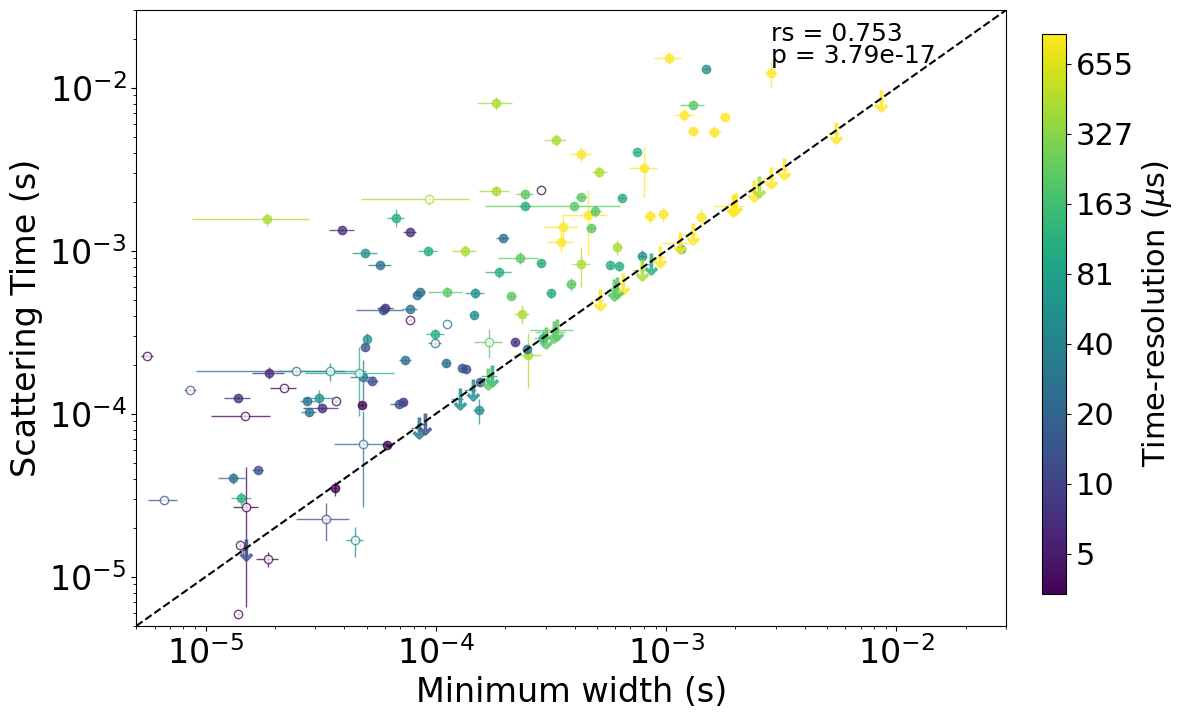

In [42]:
time_res = data_final_basecat['Time_res(s)'].to_numpy()

scat_measured = data_only_scat_final['Scattering(s)'].to_numpy()
widths_measured = data_only_scat_final['Min_width(s)'].to_numpy()
widths_measured_max= data_only_scat_final['Max_width(s)'].to_numpy()
fit_snrs = data_only_scat_final['Fit_snr'].to_numpy()
time_res_measured = data_only_scat_final['Time_res(s)'].to_numpy()
scat_err_measured = data_only_scat_final['Scattering_err_sim(s)'].to_numpy()
width_err_measured = data_only_scat_final['Min_width_err(s)'].to_numpy()
width_err_measured_max = data_only_scat_final['Max_width_err(s)'].to_numpy()
scat_measured_eg = data_only_scat_final['Sc_eg'].to_numpy()
scat_measured_gal = data_only_scat_final['MW_scat'].to_numpy()

widths_measured_upper_limits = data_no_scat_final['Min_width(s)'].to_numpy()
width_err_upper_limits = data_no_scat_final['Min_width_err(s)'].to_numpy()
widths_measured_upper_limits_max = data_no_scat_final['Max_width(s)'].to_numpy()
width_err_upper_limits_max = data_no_scat_final['Max_width_err(s)'].to_numpy()
scat_measured_upper_limits = widths_measured_upper_limits
scat_err_upper_limits = np.full(len(scat_measured_upper_limits), 1e-6)
time_res_upper_limits = data_no_scat_final['Time_res(s)'].to_numpy()
fit_snrs_upper_limits = data_no_scat_final['Fit_snr'].to_numpy()

widths_measured_profile = data_final_basecat_only_profile['Min_width(s)'].to_numpy()
width_err_profile = data_final_basecat_only_profile['Min_width_err(s)'].to_numpy()
widths_measured_profile_max = data_final_basecat_only_profile['Max_width(s)'].to_numpy()
width_err_profile_max = data_final_basecat_only_profile['Max_width_err(s)'].to_numpy()
scat_measured_profile = data_final_basecat_only_profile['Scattering(s)'].to_numpy()
scat_err_profile = data_final_basecat_only_profile['Scattering_err(s)'].to_numpy()
time_res_profile = data_final_basecat_only_profile['Time_res(s)'].to_numpy()
scat_measured_profile_eg = data_final_basecat_only_profile['Sc_eg'].to_numpy()
scat_measured_gal_eg = data_final_basecat_only_profile['MW_scat'].to_numpy()

fig = plt.figure()

# norm = mpl.colors.Normalize(vmin=np.min(time_res_measured), vmax=np.max(time_res_measured), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_measured])

tres_color, mapper = get_color_vals(time_res_measured)


for x, y, xe, ye, color in zip(widths_measured, scat_measured, width_err_measured, scat_err_measured, tres_color): 
    plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    
# norm = mpl.colors.Normalize(vmin=np.min(time_res_upper_limits), vmax=np.max(time_res_upper_limits), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_upper_limits])

tres_color, mapper = get_color_vals(time_res_upper_limits)


for x, y, xe, ye, color in zip(widths_measured_upper_limits, scat_measured_upper_limits, width_err_upper_limits, scat_err_upper_limits, tres_color): 
    plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    
    
# norm = mpl.colors.Normalize(vmin=np.min(time_res_profile), vmax=np.max(time_res_profile), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_profile])

tres_color, mapper = get_color_vals(time_res_profile)


for x, y, xe, ye, color in zip(widths_measured_profile, scat_measured_profile, width_err_profile, scat_err_profile, tres_color): 
    plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
    

x = [5e-6, 3e-2]
y = [5e-6, 3e-2]

plt.plot(x,y, linestyle='--', c='k')

plt.yscale('log')
plt.xscale('log')

plt.xlabel("Minimum width (s)")
plt.ylabel("Scattering Time (s)")

plt.xlim(5e-6, 3e-2)
plt.ylim(5e-6, 3e-2)

#### Stat test ####
val, p = scipy.stats.spearmanr(widths_measured, scat_measured)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(widths_measured)+0.00001, np.max(scat_measured)+0.004, 'rs = {}'.format(round(val,3)), fontsize=18)
plt.text(np.max(widths_measured)+0.00001, np.max(scat_measured)-0.001, "p = {:.2e}".format(p), fontsize=18)

t_res, mapper = get_color_vals(time_res)

##### Adjusting the color bar #######
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)
ytick_lab = (np.logspace(0, 8, base=2, num=9) * 2.56).astype(int)
print("Y tick labels are", ytick_lab)
cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Time-resolution ($\mu$s)', size=22)
cbar_ax.tick_params(labelsize=22)


oname = 'Paper_plots/Width_vs_scattering.jpg'
oname1 = 'Paper_plots/Width_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### DM vs Scattering ###

[ 233.0990055   600.15036935  569.48956802  581.37086844   60.96422179
  262.02102892 1299.75258546  238.19003095  119.89794457  119.89596467
  289.9839151   214.80617035  497.24504527  882.41117649 1304.21949706
  121.71280491  490.63142272  625.49750956  295.97760089 1162.34610297
  251.47703203 1241.85318085  314.87782504  137.71058532  307.91367147
  390.04683586  929.71771402  206.59877392  665.04298653  340.5463764
  343.02288535 1389.26574241  114.81635696  156.43252173  477.39771563
  963.16616657  480.66448778  657.65209453  408.93147945  480.38732278
  300.27798576  116.4085671   401.41510797  417.23449742  439.34909651
  213.06764179  966.44190681  227.70809968 1027.81125454  527.55471353
  297.01762095  749.21688653  399.77950727  948.59375075  340.55053144
  710.61640487  560.8885096   319.28364752  118.83679766  372.39369371
  637.01763447  120.48586456  192.55538997  121.18465813  653.65015928
  227.18480031  209.86681475  336.34810895  426.57311443   72.17863702
  981.6

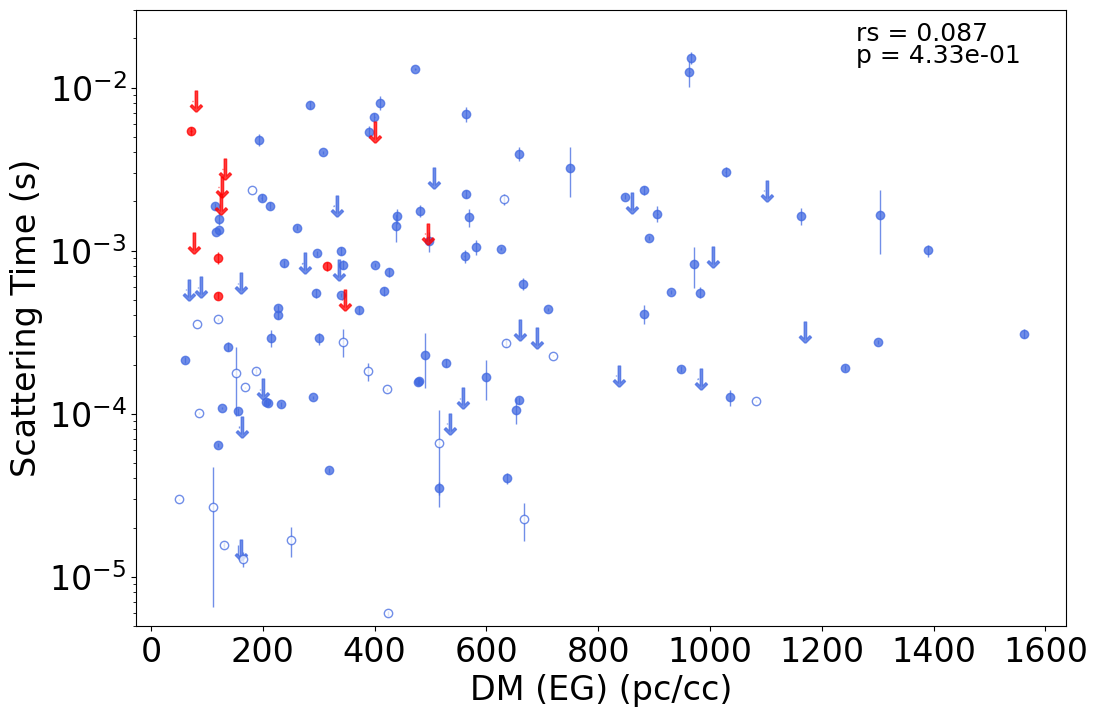

In [68]:
dms_measured = data_only_scat_final['DM_eg'].to_numpy()
print(dms_measured)
dm_err_measured = data_only_scat_final['DM_err'].to_numpy()
repeater_measured = data_only_scat_final['Repeater'].to_numpy()
events_measured = data_only_scat_final['Event'].to_numpy()


#dms_measured_mw = data_only_scat_final['MW_DM'].to_numpy()

dms_measured_upper_limits = data_no_scat_final['DM_eg'].to_numpy()
dm_err_upper_limits = data_no_scat_final['DM_err'].to_numpy()
repeater_upper_limits = data_no_scat_final['Repeater'].to_numpy()
events_upper_limits = data_no_scat_final['Event'].to_numpy()
#dms_measured_mw_upper_limits = data_no_scat_final['MW_DM'].to_numpy()

dms_measured_profile = data_final_basecat_only_profile['DM_eg'].to_numpy()
dm_err_profile = data_final_basecat_only_profile['DM_err'].to_numpy()
repeater_profile = data_final_basecat_only_profile['Repeater'].to_numpy()
events_profile = data_final_basecat_only_profile['Event'].to_numpy()
#dms_measured_mw_profile = data_final_basecat_only_profile['MW_DM'].to_numpy()

# repeater = data_final_basecat['Repeater'].to_numpy()

#### Removing events with scattering time less than 3 times of what is expected from galaxy ######

rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

dms_measured_del = np.delete(dms_measured, id_x)
scat_measured_eg_del = np.delete(scat_measured_eg, id_x)
dm_err_measured_del = np.delete(dm_err_measured, id_x)
scat_err_measured_del = np.delete(scat_err_measured, id_x)
repeater_measured_del = np.delete(repeater_measured, id_x)
events_measured_del = np.delete(events_measured, id_x)

fig = plt.figure()

# norm = mpl.colors.Normalize(vmin=np.min(time_res_measured), vmax=np.max(time_res_measured), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_measured])

tres_color=np.full(len(scat_measured_eg_del),'royalblue')
for x, y, xe, ye, color, r, e in zip(dms_measured_del, scat_measured_eg_del, dm_err_measured_del, scat_err_measured_del, tres_color, repeater_measured_del, events_measured_del):
    if r:
        # print(e, r, x)
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o', label='Repeater')
    else:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o', label='Non Repeater')
    
# norm = mpl.colors.Normalize(vmin=np.min(time_res_upper_limits), vmax=np.max(time_res_upper_limits), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_upper_limits])

tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color, r, e in zip(dms_measured_upper_limits, scat_measured_upper_limits, dm_err_upper_limits, scat_err_upper_limits, tres_color, repeater_upper_limits, events_upper_limits): 
    if r:
        print(e, r, x)
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15, label='Repeater')
    else:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15, label='Non Repeater')
    
    
# norm = mpl.colors.Normalize(vmin=np.min(time_res_profile), vmax=np.max(time_res_profile), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_profile])


tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color, r, e in zip(dms_measured_profile, scat_measured_profile_eg, dm_err_profile, scat_err_profile, tres_color, repeater_profile, events_profile):
    if r:
        # print(e, r, x)
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec='r', zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor='r', label='Repeater')
    else:
        # print(e, x, y)
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color, label='Non Repeater')
    


plt.yscale('log')
#plt.xscale('log')

plt.xlabel("DM (EG) (pc/cc)")
plt.ylabel("Scattering Time (s)")

plt.ylim(5e-6, 3e-2)

# dm_z_line = np.linspace(0.2, 1.8, 9)
# dms_z = 855 * dm_z_line

# for i in range(len(dms_z)):
#     plt.axvline(dms_z[i], c='k', alpha=0.2, linestyle='--')
#     plt.text(dms_z[i],1e-5,'z = {}'.format(str(round(dm_z_line[i],1))),rotation=90, alpha=0.2)

#### Stat test ####
val, p = scipy.stats.spearmanr(dms_measured, scat_measured_eg)
print(round(val,8))
print("{:.8e}".format(p))

val, p = scipy.stats.spearmanr(dms_measured_del, scat_measured_eg_del)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(dms_measured)-300, np.max(scat_measured)+0.004, 'rs = {}'.format(round(val,3)), fontsize=18)
plt.text(np.max(dms_measured)-300, np.max(scat_measured)-0.001, "p = {:.2e}".format(p), fontsize=18)

##### Adjusting the color bar #######
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)
# ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
# cbar_ax.tick_params(labelsize=12)

oname = 'Paper_plots/DM_vs_scattering.jpg'
oname1 = 'Paper_plots/DM_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

[ 233.0990055   600.15036935  569.48956802  581.37086844   60.96422179
  262.02102892 1299.75258546  238.19003095  119.89794457  119.89596467
  289.9839151   214.80617035  497.24504527  882.41117649 1304.21949706
  121.71280491  490.63142272  625.49750956  295.97760089 1162.34610297
  251.47703203 1241.85318085  314.87782504  137.71058532  307.91367147
  390.04683586  929.71771402  206.59877392  665.04298653  340.5463764
  343.02288535 1389.26574241  114.81635696  156.43252173  477.39771563
  963.16616657  480.66448778  657.65209453  408.93147945  480.38732278
  300.27798576  116.4085671   401.41510797  417.23449742  439.34909651
  213.06764179  966.44190681  227.70809968 1027.81125454  527.55471353
  297.01762095  749.21688653  399.77950727  948.59375075  340.55053144
  710.61640487  560.8885096   319.28364752  118.83679766  372.39369371
  637.01763447  120.48586456  192.55538997  121.18465813  653.65015928
  227.18480031  209.86681475  336.34810895  426.57311443   72.17863702
  981.6

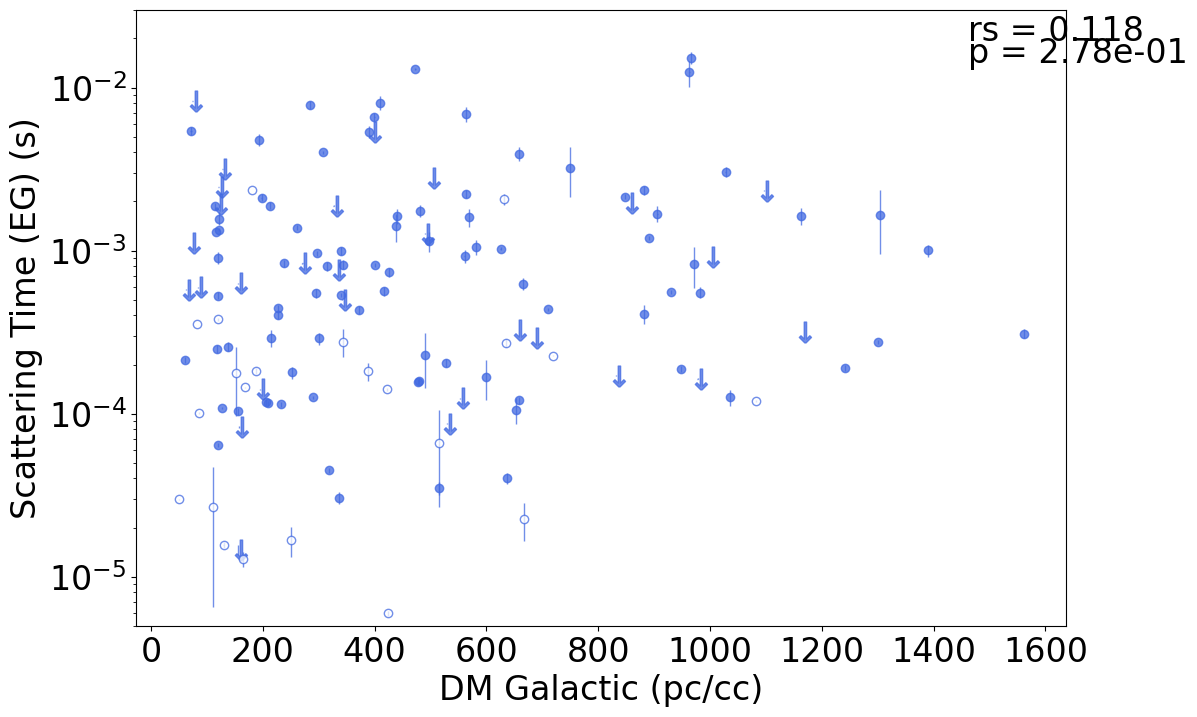

In [45]:
dms_measured = data_only_scat_final['DM_eg'].to_numpy()
print(dms_measured)
dm_err_measured = data_only_scat_final['DM_err'].to_numpy()
#dms_measured_mw = data_only_scat_final['MW_DM'].to_numpy()

dms_measured_upper_limits = data_no_scat_final['DM_eg'].to_numpy()
dm_err_upper_limits = data_no_scat_final['DM_err'].to_numpy()
#dms_measured_mw_upper_limits = data_no_scat_final['MW_DM'].to_numpy()

dms_measured_profile = data_final_basecat_only_profile['DM_eg'].to_numpy()
dm_err_profile = data_final_basecat_only_profile['DM_err'].to_numpy()
#dms_measured_mw_profile = data_final_basecat_only_profile['MW_DM'].to_numpy()

fig = plt.figure()

# norm = mpl.colors.Normalize(vmin=np.min(time_res_measured), vmax=np.max(time_res_measured), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_measured])

tres_color=np.full(len(scat_measured),'royalblue')
for x, y, xe, ye, color in zip(dms_measured, scat_measured_eg, dm_err_measured, scat_err_measured, tres_color): 
    plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    
# norm = mpl.colors.Normalize(vmin=np.min(time_res_upper_limits), vmax=np.max(time_res_upper_limits), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_upper_limits])

tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color in zip(dms_measured_upper_limits, scat_measured_upper_limits, dm_err_upper_limits, scat_err_upper_limits, tres_color): 
    plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    
    
# norm = mpl.colors.Normalize(vmin=np.min(time_res_profile), vmax=np.max(time_res_profile), clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
# tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_profile])


tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color in zip(dms_measured_profile, scat_measured_profile_eg, dm_err_profile, scat_err_profile, tres_color): 
    plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
    


plt.yscale('log')
#plt.xscale('log')

plt.xlabel("DM Galactic (pc/cc)")
plt.ylabel("Scattering Time (EG) (s)")

plt.ylim(5e-6, 3e-2)

#### Stat test ####
val, p = scipy.stats.spearmanr(dms_measured, scat_measured)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(dms_measured)-100, np.max(scat_measured)+0.004, 'rs = {}'.format(round(val,3)))
plt.text(np.max(dms_measured)-100, np.max(scat_measured)-0.001, "p = {:.2e}".format(p))


##### Adjusting the color bar #######
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)
# ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
# cbar_ax.tick_params(labelsize=12)

# oname = 'Paper_plots/DM_vs_scattering.jpg'
# oname1 = 'Paper_plots/DM_vs_scattering.pdf'

# plt.savefig(oname, dpi=300, bbox_inches='tight')
# plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### RM vs Scattering ###

[  -5.4   -6.4   48.6    9.   -26.5   32.3  244.5    1.6  470.4   35.1
   14.1    8.3   -7.8  372.4   -2.9    0.   -11.2  -78.1 -187.9  -25.5
  -38.3   -6.9]
[  14    8    2   -4  -16   21  -15  -23    5  -31    9   49  -17   -8
    5 9999  -11  -15  -39    9  -10   12]
-0.14512298
1.79871540e-01
-0.16298116
1.38529635e-01


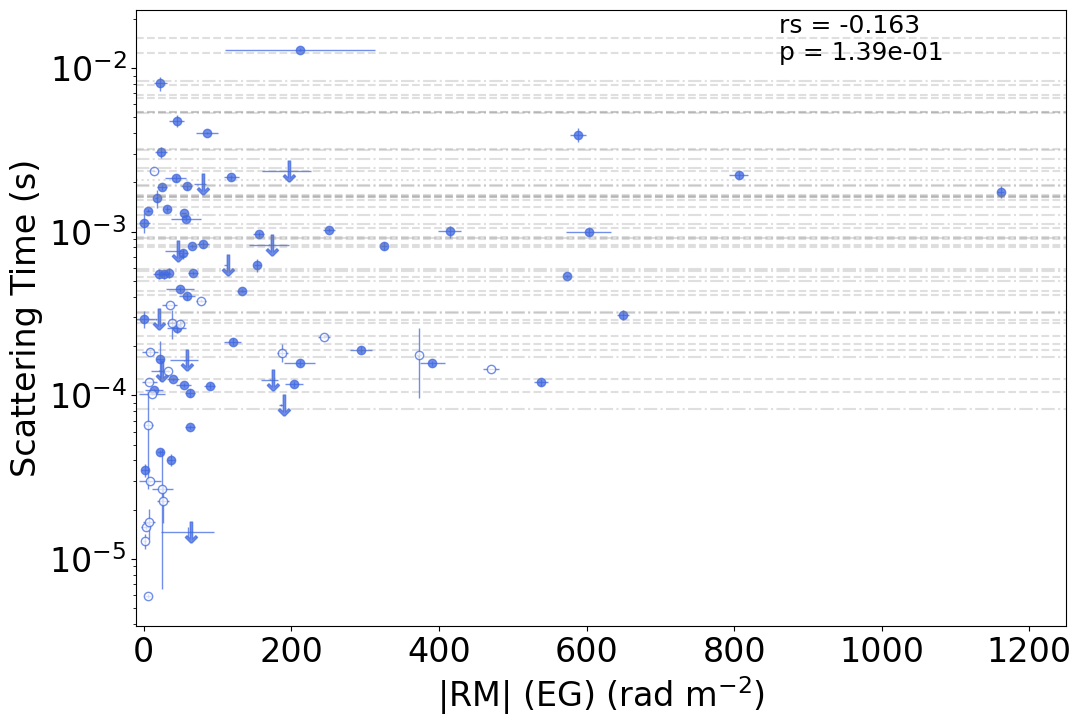

In [69]:
rms_measured = data_only_scat_final['RM_eg'].to_numpy()
rm_err_measured = data_only_scat_final['RM_eg_err'].to_numpy()
rms_measured_mw = data_only_scat_final['MW_RM'].to_numpy()
# rms_measured = rms_measured - rms_measured_mw
#pol_frac_measured = data_only_scat_final['Pol_frac'].to_numpy()

rms_measured_upper_limits = data_no_scat_final['RM_eg'].to_numpy()
rm_err_upper_limits = data_no_scat_final['RM_eg_err'].to_numpy()
rms_measured_mw_upper_limits = data_no_scat_final['MW_RM'].to_numpy()
# rms_measured_upper_limits = rms_measured_upper_limits - rms_measured_mw_upper_limits

rms_measured_profile = data_final_basecat_only_profile['RM_eg'].to_numpy()
print(rms_measured_profile)
rm_err_profile = data_final_basecat_only_profile['RM_eg_err'].to_numpy()
rms_measured_mw_profile = data_final_basecat_only_profile['MW_RM'].to_numpy()
print(rms_measured_mw_profile)
# rms_measured_profile = rms_measured_profile - rms_measured_mw_profile

rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

rms_measured_del = np.delete(rms_measured, id_x)
# scat_measured_eg_del = np.delete(scat_measured_eg, id_x)
rm_err_measured_del = np.delete(rm_err_measured, id_x)
# scat_err_measured_del = np.delete(scat_err_measured, id_x)
repeater_measured_del = np.delete(repeater_measured, id_x)


fig = plt.figure()

tres_color=np.full(len(scat_measured_eg_del),'royalblue')
for x, y, xe, ye, color, r in zip(rms_measured_del, scat_measured_eg_del, rm_err_measured_del, scat_err_measured_del, tres_color, repeater_measured_del):
    if x != 0 and not r:
        plt.errorbar(abs(x), y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x!= 0 and r:
        plt.errorbar(abs(x), y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        #plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
        plt.axhline(y, linestyle='--', c='gray', alpha=0.25)
    

tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color, r in zip(rms_measured_upper_limits, scat_measured_upper_limits, rm_err_upper_limits, scat_err_upper_limits, tres_color, repeater_upper_limits): 
    if x != 0 and not r:
        plt.errorbar(abs(x), y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    elif x!= 0 and r:
        plt.errorbar(abs(x), y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    else:
        # plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
        plt.axhline(y, linestyle='-.', c='gray', alpha=0.25)
    
    

tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color, r in zip(rms_measured_profile, scat_measured_profile_eg, rm_err_profile, scat_err_profile, tres_color, repeater_profile):
    if x != 0 and not r:
        plt.errorbar(abs(x), y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
    elif x!= 0 and r:
        plt.errorbar(abs(x), y, xerr=xe, yerr=ye, lw=1, mec='r', zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor='r')
    else:
        #plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
        plt.axhline(y, linestyle=':', c='gray', alpha=0.25)
        
    


plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r"|RM| (EG) (rad m$^{-2}$)")
plt.ylabel("Scattering Time (s)")

plt.xlim(-10, 1250)

#### Stat test ####
val, p = scipy.stats.spearmanr(abs(rms_measured), scat_measured_eg)
print(round(val,8))
print("{:.8e}".format(p))

val, p = scipy.stats.spearmanr(abs(rms_measured_del), scat_measured_eg_del)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(rms_measured)-300, np.max(scat_measured)+0.001, 'rs = {}'.format(round(val,3)), fontsize=18)
plt.text(np.max(rms_measured)-300, np.max(scat_measured)-0.004, "p = {:.2e}".format(p), fontsize=18)


##### Adjusting the color bar #######
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)
# ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
# cbar_ax.tick_params(labelsize=12)

oname = 'Paper_plots/RM_vs_scattering.jpg'
oname1 = 'Paper_plots/RM_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Polarization Fraction vs Scattering ###

-0.17411837
1.06760897e-01
-0.1420574
1.97392103e-01


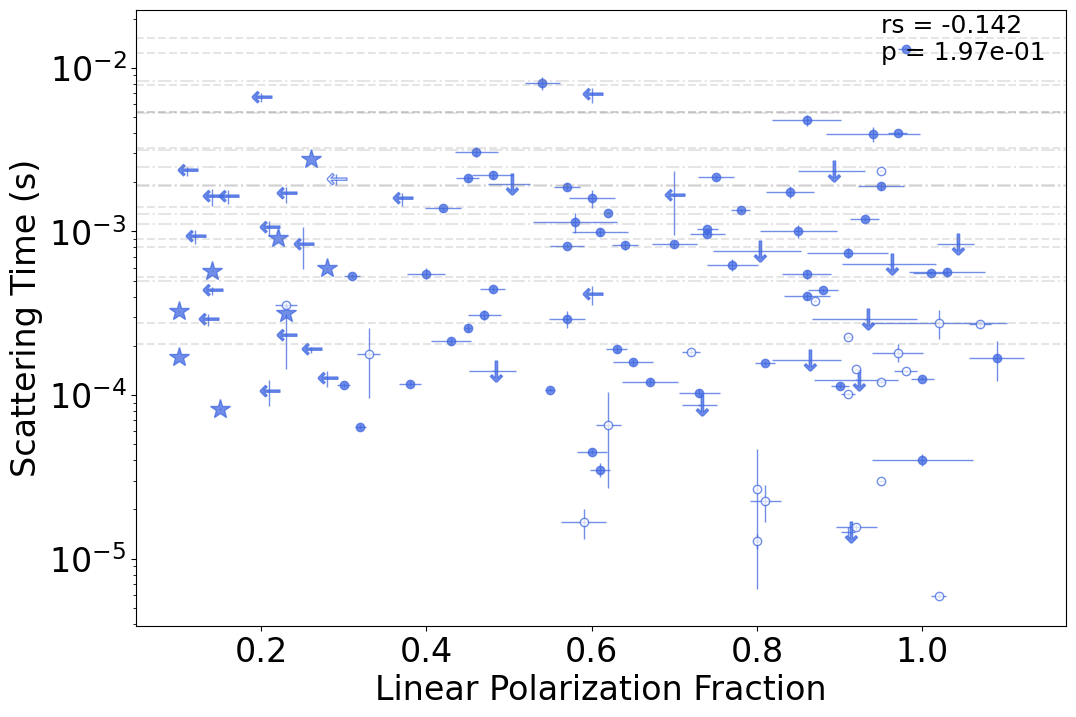

In [56]:
# data_pol_measured = data_final_basecat[(data_final_basecat['Pol_frac'] > 0)]

# data_pol_upper = data_final_basecat[(data_final_basecat['Pol_frac_upper'] > 0)]

# data_no_pol = data_final_basecat[(data_final_basecat['Pol_frac'] < 0) & (data_final_basecat['Pol_frac_upper'] < 0)]


# scat_measured = data_pol_measured['Scattering(s)'].to_numpy()
# scat_measured_err = data_pol_measured['Scattering_err_sim(s)'].to_numpy()
# p_frac_measured = data_pol_measured['Pol_frac'].to_numpy()
# p_frac_measured_err = data_pol_measured['Pol_frac_err'].to_numpy()


# scat_upper = 

# data_final_basecat = data_basecat[(data_basecat['Min_width(s)'] > 5e-6)]




pol_fracs_measured = data_only_scat_final['Pol_frac'].to_numpy()
pol_frac_err_measured = data_only_scat_final['Pol_frac_err'].to_numpy()

pol_fracs_measured_upper = data_only_scat_final['Pol_frac_upper'].to_numpy()


pol_fracs_measured_upper_limits = data_no_scat_final['Pol_frac'].to_numpy()
pol_frac_err_upper_limits = data_no_scat_final['Pol_frac_err'].to_numpy()

pol_fracs_measured_upper_limits_upper = data_no_scat_final['Pol_frac_upper'].to_numpy()


pol_fracs_measured_profile = data_final_basecat_only_profile['Pol_frac'].to_numpy()
pol_frac_err_profile = data_final_basecat_only_profile['Pol_frac_err'].to_numpy()

pol_fracs_measured_profile_upper = data_final_basecat_only_profile['Pol_frac_upper'].to_numpy()


rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

pol_fracs_measured_del = np.delete(pol_fracs_measured, id_x)
# scat_measured_eg_del = np.delete(scat_measured_eg, id_x)
pol_frac_err_measured_del = np.delete(pol_frac_err_measured, id_x)
# scat_err_measured_del = np.delete(scat_err_measured, id_x)
pol_fracs_measured_upper_del = np.delete(pol_fracs_measured_upper, id_x)

fig = plt.figure()

tres_color=np.full(len(scat_measured_eg_del),'royalblue')
for x, y, xe, ye, color, r in zip(pol_fracs_measured_del, scat_measured_eg_del, pol_frac_err_measured_del, scat_err_measured_del, tres_color, pol_fracs_measured_upper_del):
    if x > 0 and r < 0 :
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x < 0 and r > 0:
        plt.errorbar(r, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\leftarrow$', markersize=15)
    else:
        #plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
        plt.axhline(y, linestyle='--', c='gray', alpha=0.2)
    

tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color, r in zip(pol_fracs_measured_upper_limits, scat_measured_upper_limits, pol_frac_err_upper_limits, scat_err_upper_limits, tres_color, pol_fracs_measured_upper_limits_upper): 
    if x > 0 and r < 0:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    elif x < 0 and r > 0:
        plt.errorbar(r, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = '*', markersize=15)
    else:
        # plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
        plt.axhline(y, linestyle='-.', c='gray', alpha=0.2)
    
    

tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color, r in zip(pol_fracs_measured_profile, scat_measured_profile_eg, pol_frac_err_profile, scat_err_profile, tres_color, pol_fracs_measured_profile_upper):
    if x > 0 and r < 0:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
    elif x < 0 and r > 0:
        plt.errorbar(r, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = r'$\leftarrow$', mfc='w', ecolor=color, markersize=15)
    else:
        #plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
    


plt.yscale('log')
#plt.xscale('log')

plt.xlabel("Linear Polarization Fraction")
plt.ylabel("Scattering Time (s)")

### stats ####
val, p = scipy.stats.spearmanr(pol_fracs_measured, scat_measured_eg)
print(round(val,8))
print("{:.8e}".format(p))

val, p = scipy.stats.spearmanr(pol_fracs_measured_del, scat_measured_eg_del)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(0.95, np.max(scat_measured)+0.001, 'rs = {}'.format(round(val,3)), fontsize=18)
plt.text(0.95, np.max(scat_measured)-0.004, "p = {:.2e}".format(p), fontsize=18)



##### Adjusting the color bar #######
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)
# ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
# cbar_ax.tick_params(labelsize=12)

oname = 'Paper_plots/Polfrac_vs_scattering.jpg'
oname1 = 'Paper_plots/Polfrac_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Sigma_RM vs Scattering

-0.21353928
4.70418290e-02


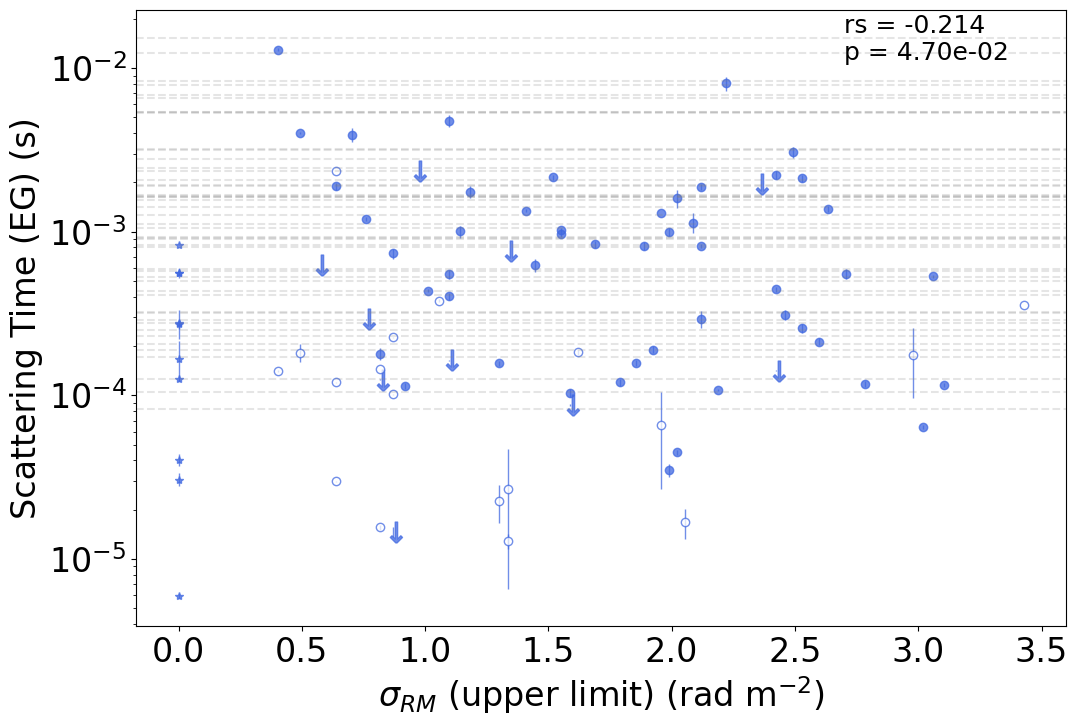

In [57]:
sig_RM_measured = data_only_scat_final['Sig_RM_limit'].to_numpy()
sig_RM_err_measured = np.zeros(len(sig_RM_measured))

sig_RM_upper_limits = data_no_scat_final['Sig_RM_limit'].to_numpy()
sig_RM_err_upper_limits = np.zeros(len(sig_RM_upper_limits))
                              
sig_RM_profile = data_final_basecat_only_profile['Sig_RM_limit'].to_numpy()
sig_RM_err_profile = np.zeros(len(sig_RM_profile))

fig = plt.figure()

tres_color=np.full(len(scat_measured),'royalblue')
for x, y, xe, ye, color, r in zip(sig_RM_measured, scat_measured_eg, sig_RM_err_measured, scat_err_measured, tres_color, repeater_measured):
    if x == 0 :
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = '*')
    elif x < 0:
        plt.axhline(y, linestyle='--', c='gray', alpha=0.2)
    else:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
        #plt.errorbar(-700, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    

tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color, r in zip(sig_RM_upper_limits, scat_measured_upper_limits, sig_RM_err_upper_limits, scat_err_upper_limits, tres_color, repeater_upper_limits): 
    if x == 0 :
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = '*')
    elif x < 0:
        plt.axhline(y, linestyle='--', c='gray', alpha=0.2)
    else:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    
    

tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color, r in zip(sig_RM_profile, scat_measured_profile_eg, sig_RM_err_profile, scat_err_profile, tres_color, repeater_profile):
    if x == 0 :
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = '*')
    elif x < 0:
        plt.axhline(y, linestyle='--', c='gray', alpha=0.2)
    else:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
        
    


plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r"$\sigma_{RM}$ (upper limit) (rad m$^{-2}$)")
plt.ylabel("Scattering Time (EG) (s)")

### stats ####
val, p = scipy.stats.spearmanr(sig_RM_measured, scat_measured_eg)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(2.7, np.max(scat_measured)+0.001, 'rs = {}'.format(round(val,3)), fontsize=18)
plt.text(2.7, np.max(scat_measured)-0.004, "p = {:.2e}".format(p), fontsize=18)



##### Adjusting the color bar #######
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)
# ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
# cbar_ax.tick_params(labelsize=12)

oname = 'Paper_plots/SigRM_vs_scattering.jpg'
oname1 = 'Paper_plots/SigRM_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Fluence vs Scattering ####

0.00729967
9.46499805e-01
-0.02940224
7.90627743e-01


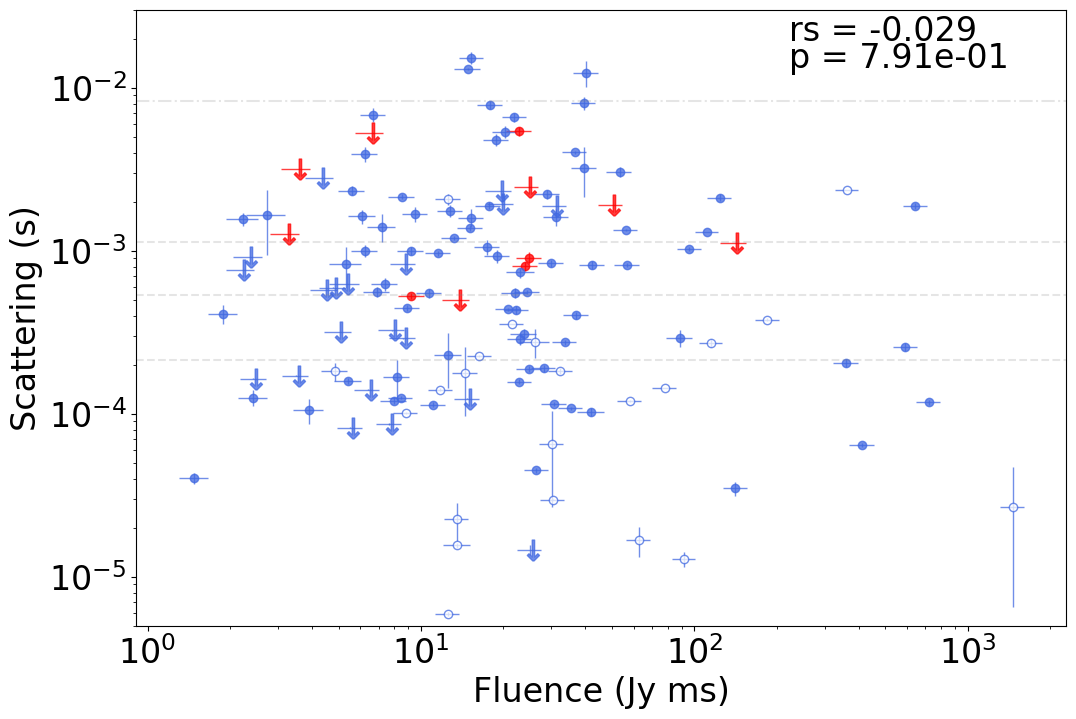

In [70]:
fluences_measured = data_only_scat_final['Fluence(Jy_ms)'].to_numpy()
fluence_err_measured = data_only_scat_final['Fluence_err(Jy_ms)'].to_numpy()

fluences_measured_upper_limits = data_no_scat_final['Fluence(Jy_ms)'].to_numpy()
fluence_err_upper_limits = data_no_scat_final['Fluence_err(Jy_ms)'].to_numpy()


fluences_measured_profile = data_final_basecat_only_profile['Fluence(Jy_ms)'].to_numpy()
fluence_err_profile = data_final_basecat_only_profile['Fluence_err(Jy_ms)'].to_numpy()

rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

fluences_measured_del = np.delete(fluences_measured, id_x)
# scat_measured_eg_del = np.delete(scat_measured_eg, id_x)
fluence_err_measured_del = np.delete(fluence_err_measured, id_x)
# scat_err_measured_del = np.delete(scat_err_measured, id_x)
repeater_measured_del = np.delete(repeater_measured, id_x)


fig = plt.figure()

tres_color=np.full(len(scat_measured_eg_del),'royalblue')
for x, y, xe, ye, color, r in zip(fluences_measured_del, scat_measured_eg_del, fluence_err_measured_del, scat_err_measured_del, tres_color, repeater_measured_del):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle='--', c='gray', alpha=0.2)
    

tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color, r in zip(fluences_measured_upper_limits, scat_measured_upper_limits, fluence_err_upper_limits, scat_err_upper_limits, tres_color, repeater_upper_limits): 
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    else:
        plt.axhline(y, linestyle='-.', c='gray', alpha=0.2)
    
    

tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color, r in zip(fluences_measured_profile, scat_measured_profile_eg, fluence_err_profile, scat_err_profile, tres_color, repeater_profile):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec='r', zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor='r')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
    


plt.yscale('log')
plt.xscale('log')

plt.xlabel("Fluence (Jy ms)")
plt.ylabel("Scattering (s)")

plt.ylim(5e-6, 3e-2)

#### Stat test ####
# fluences_measured_comb = np.concatenate((fluences_measured, fluences_measured_profile, fluences_measured_upper_limits))
# print(len(fluences_measured_comb))
# scat_measured_comb = np.concatenate((scat_measured, scat_measured_profile, scat_measured_upper_limits))
# print(len(scat_measured_comb))

# val, p = scipy.stats.spearmanr(fluences_measured_comb, scat_measured_comb)
val, p = scipy.stats.spearmanr(fluences_measured, scat_measured_eg)
print(round(val,8))
print("{:.8e}".format(p))

val, p = scipy.stats.spearmanr(fluences_measured_del, scat_measured_eg_del)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluences_measured)-500, np.max(scat_measured)+0.004, 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluences_measured)-500, np.max(scat_measured)-0.002, "p = {:.2e}".format(p))

##### Adjusting the color bar #######
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cb = fig.colorbar(mapper, cax=cbar_ax)
# ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
# cbar_ax.set_yticklabels(ytick_lab)
# cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
# cbar_ax.tick_params(labelsize=12)

oname = 'Paper_plots/Fluence_vs_scattering.jpg'
oname1 = 'Paper_plots/Fluence_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Flux vs Scattering ###

-0.51798489
2.77254141e-07


/tmp/ipykernel_3097/1576012592.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(ytick_lab)


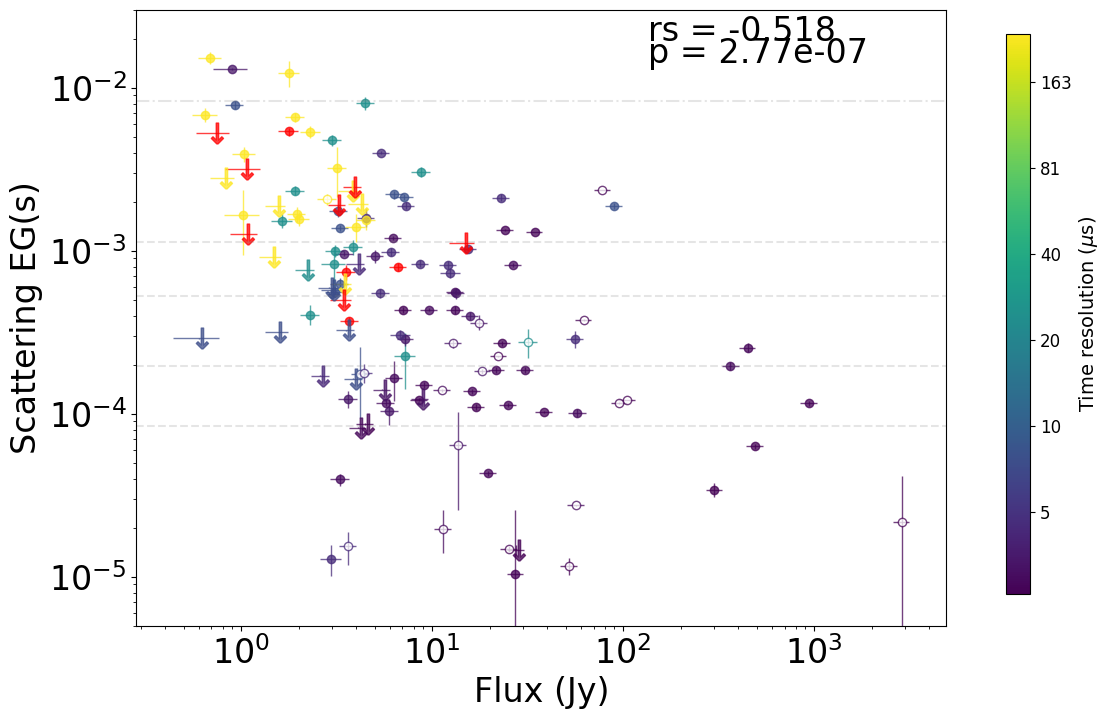

In [21]:
fluxes_measured = data_only_scat_final['Flux(Jy)'].to_numpy()
flux_err_measured = data_only_scat_final['Flux_err(Jy)'].to_numpy()

fluxes_measured_upper_limits = data_no_scat_final['Flux(Jy)'].to_numpy()
flux_err_upper_limits = data_no_scat_final['Flux_err(Jy)'].to_numpy()

fluxes_measured_profile = data_final_basecat_only_profile['Flux(Jy)'].to_numpy()
flux_err_profile = data_final_basecat_only_profile['Flux_err(Jy)'].to_numpy()

fig = plt.figure()

#tres_color=np.full(len(scat_measured),'royalblue')

norm = mpl.colors.Normalize(vmin=np.min(time_res_measured), vmax=np.max(time_res_measured), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_measured])


for x, y, xe, ye, color, r in zip(fluxes_measured, scat_measured_eg, flux_err_measured, scat_err_measured, tres_color, repeater_measured):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle='--', c='gray', alpha=0.2)
        

norm = mpl.colors.Normalize(vmin=np.min(time_res_upper_limits), vmax=np.max(time_res_upper_limits), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_upper_limits])
    

#tres_color=np.full(len(scat_measured_upper_limits),'royalblue')
for x, y, xe, ye, color, r in zip(fluxes_measured_upper_limits, scat_measured_upper_limits, flux_err_upper_limits, scat_err_upper_limits, tres_color, repeater_upper_limits): 
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\downarrow$', markersize=15)
    else:
        plt.axhline(y, linestyle='-.', c='gray', alpha=0.2)
    
    

norm = mpl.colors.Normalize(vmin=np.min(time_res_profile), vmax=np.max(time_res_profile), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
tres_color = np.array([(mapper.to_rgba(v)) for v in time_res_profile])

#tres_color=np.full(len(scat_measured_profile),'royalblue')
for x, y, xe, ye, color, r in zip(fluxes_measured_profile, scat_measured_profile_eg, flux_err_profile, scat_err_profile, tres_color, repeater_profile):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec=color, zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor=color)
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, mec='r', zorder=1, alpha=0.75, marker = 'o', mfc='w', ecolor='r')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
    


plt.yscale('log')
plt.xscale('log')

plt.xlabel("Flux (Jy)")
plt.ylabel("Scattering EG(s)")

plt.ylim(5e-6, 3e-2)

#### Stat test ####
# fluxes_measured_comb = np.concatenate((fluxes_measured, fluxes_measured_profile, fluxes_measured_upper_limits))
# print(len(fluxes_measured_comb))
# scat_measured_comb = np.concatenate((scat_measured, scat_measured_profile, scat_measured_upper_limits))
# print(len(scat_measured_comb))

# val, p = scipy.stats.spearmanr(fluences_measured_comb, scat_measured_comb)
val, p = scipy.stats.spearmanr(fluxes_measured, scat_measured)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluxes_measured)-800, np.max(scat_measured)+0.004, 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluxes_measured)-800, np.max(scat_measured)-0.001, "p = {:.2e}".format(p))

##### Adjusting the color bar #######
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)
ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Time resolution ($\mu$s)', size=14)
cbar_ax.tick_params(labelsize=12)

oname = 'Paper_plots/Flux_vs_scattering.jpg'
oname1 = 'Paper_plots/Flux_vs_scattering.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Fluence vs DM ###

-0.19930646
1.95473898e-02


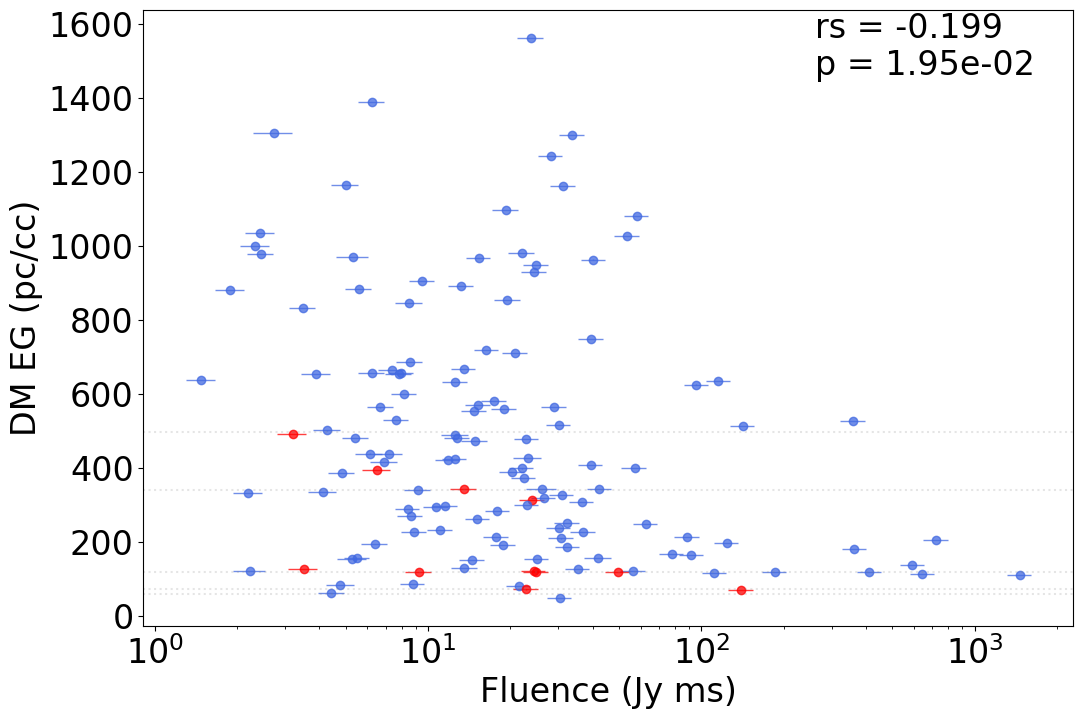

In [51]:
# fluences_measured_comb = np.concatenate((fluences_measured, fluences_measured_profile, fluences_measured_upper_limits))

# dms_measured_comb = np.concatenate((dms_measured, dms_measured_profile, dms_measured_upper_limits))

# print(len(dms_measured_comb))

# fluences_err_measured_comb = np.concatenate((fluence_err_measured, fluence_err_profile, fluence_err_upper_limits))

# dms_err_measured_comb = np.concatenate((dm_err_measured, dm_err_profile, dm_err_upper_limits))

# repeaters_comb = np.concatenate((repeater_measured, repeater_profile, repeater_upper_limits))


fluences_measured_comb = data_final_basecat['Fluence(Jy_ms)'].to_numpy()
fluences_err_measured_comb = data_final_basecat['Fluence_err(Jy_ms)'].to_numpy()
dms_measured_comb = data_final_basecat['DM_eg'].to_numpy()
dms_err_measured_comb = data_final_basecat['DM_err'].to_numpy()

tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(fluences_measured_comb, dms_measured_comb, fluences_err_measured_comb, dms_err_measured_comb, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
#plt.yscale('log')
plt.xscale('log')

plt.xlabel("Fluence (Jy ms)")
plt.ylabel("DM EG (pc/cc)")

#### Stats test #####
val, p = scipy.stats.spearmanr(fluences_measured_comb, dms_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluences_measured_comb)-1200, np.max(dms_measured_comb), 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluences_measured_comb)-1200, np.max(dms_measured_comb)-100, "p = {:.2e}".format(p))

oname = 'Paper_plots/Fluence_vs_DM.jpg'
oname1 = 'Paper_plots/Fluence_vs_DM.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Flux vs DM ###

-0.20162137
1.81466906e-02


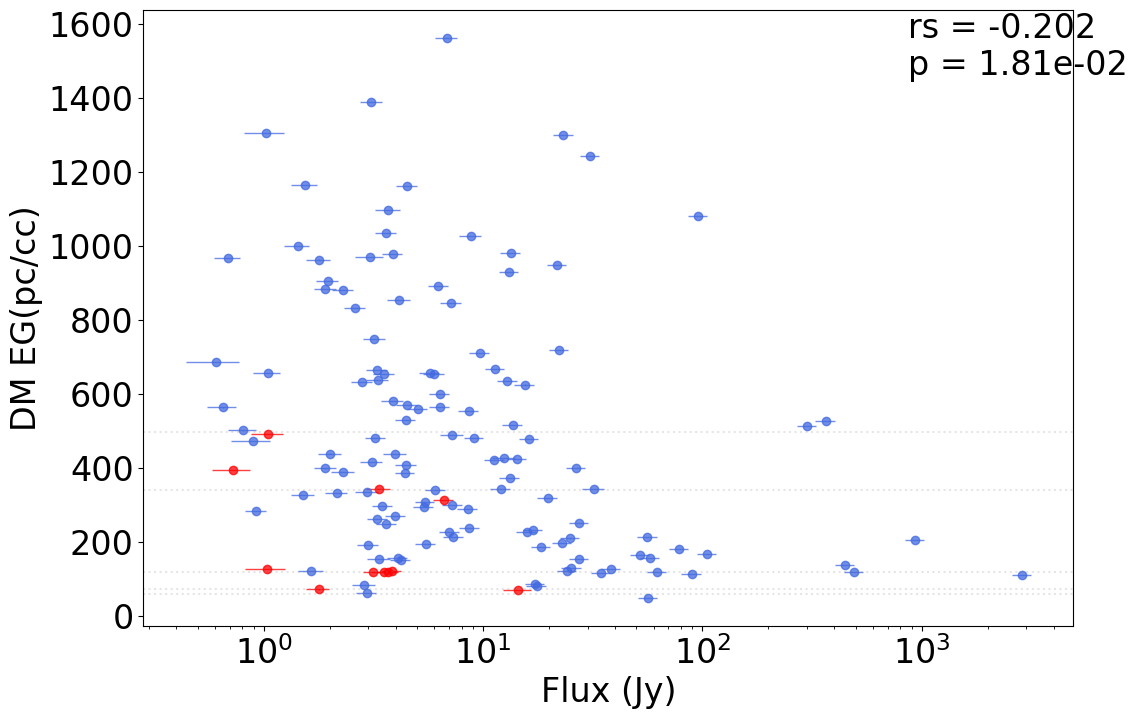

In [55]:
# fluxes_measured_comb = np.concatenate((fluxes_measured, fluxes_measured_profile, fluxes_measured_upper_limits))

# dms_measured_comb = np.concatenate((dms_measured, dms_measured_profile, dms_measured_upper_limits))
# print(dms_measured_comb)

# fluxes_err_measured_comb = np.concatenate((flux_err_measured, flux_err_profile, flux_err_upper_limits))

# dms_err_measured_comb = np.concatenate((dm_err_measured, dm_err_profile, dm_err_upper_limits))

fluxes_measured_comb = data_final_basecat['Flux(Jy)'].to_numpy()
fluxes_err_measured_comb = data_final_basecat['Flux_err(Jy)'].to_numpy()

tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(fluxes_measured_comb, dms_measured_comb, fluxes_err_measured_comb, dms_err_measured_comb, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
#plt.yscale('log')
plt.xscale('log')

plt.xlabel("Flux (Jy)")
plt.ylabel("DM EG(pc/cc)")

#### Stats test #####
val, p = scipy.stats.spearmanr(fluxes_measured_comb, dms_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluxes_measured_comb)-2000, np.max(dms_measured_comb), 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluxes_measured_comb)-2000, np.max(dms_measured_comb)-100, "p = {:.2e}".format(p))

oname = 'Paper_plots/Flux_vs_DM.jpg'
oname1 = 'Paper_plots/Flux_vs_DM.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Minimum Width vs DM ###

0.14991506
8.03725396e-02


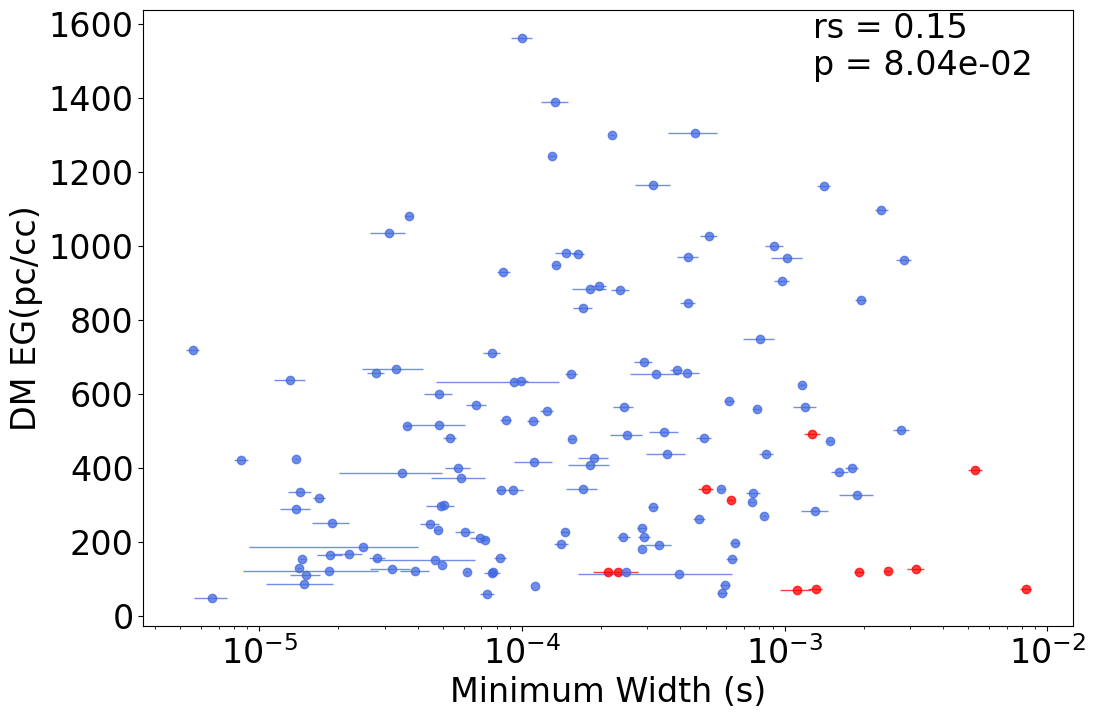

In [74]:
# widths_measured_comb = np.concatenate((widths_measured, widths_measured_profile, widths_measured_upper_limits))
# widths_measured_comb_max = np.concatenate((widths_measured_max, widths_measured_profile_max, widths_measured_upper_limits_max))

# dms_measured_comb = np.concatenate((dms_measured, dms_measured_profile, dms_measured_upper_limits))

# widths_err_measured_comb = np.concatenate((width_err_measured, width_err_profile, width_err_upper_limits))
# widths_err_measured_comb_max = np.concatenate((width_err_measured_max, width_err_profile_max, width_err_upper_limits_max))

# dms_err_measured_comb = np.concatenate((dm_err_measured, dm_err_profile, dm_err_upper_limits))

dms_measured_comb = data_final_basecat['DM_eg'].to_numpy()
widths_measured_comb = data_final_basecat['Min_width(s)'].to_numpy()
widths_err_measured_comb = data_final_basecat['Min_width_err(s)'].to_numpy()
dms_err_measured_comb = data_final_basecat['DM_err'].to_numpy()
repeaters_comb = data_final_basecat['Repeater'].to_numpy()

tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(widths_measured_comb, dms_measured_comb, widths_err_measured_comb, dms_err_measured_comb, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
#plt.yscale('log')
plt.xscale('log')

plt.xlabel("Minimum Width (s)")
plt.ylabel("DM EG(pc/cc)")

#### Stats test #####
val, p = scipy.stats.spearmanr(widths_measured_comb, dms_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(widths_measured_comb)-0.007, np.max(dms_measured_comb), 'rs = {}'.format(round(val,3)))
plt.text(np.max(widths_measured_comb)-0.007, np.max(dms_measured_comb)-100, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_vs_DM.jpg'
oname1 = 'Paper_plots/Width_vs_DM.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Width vs DM ####

0.14991506
8.03725396e-02


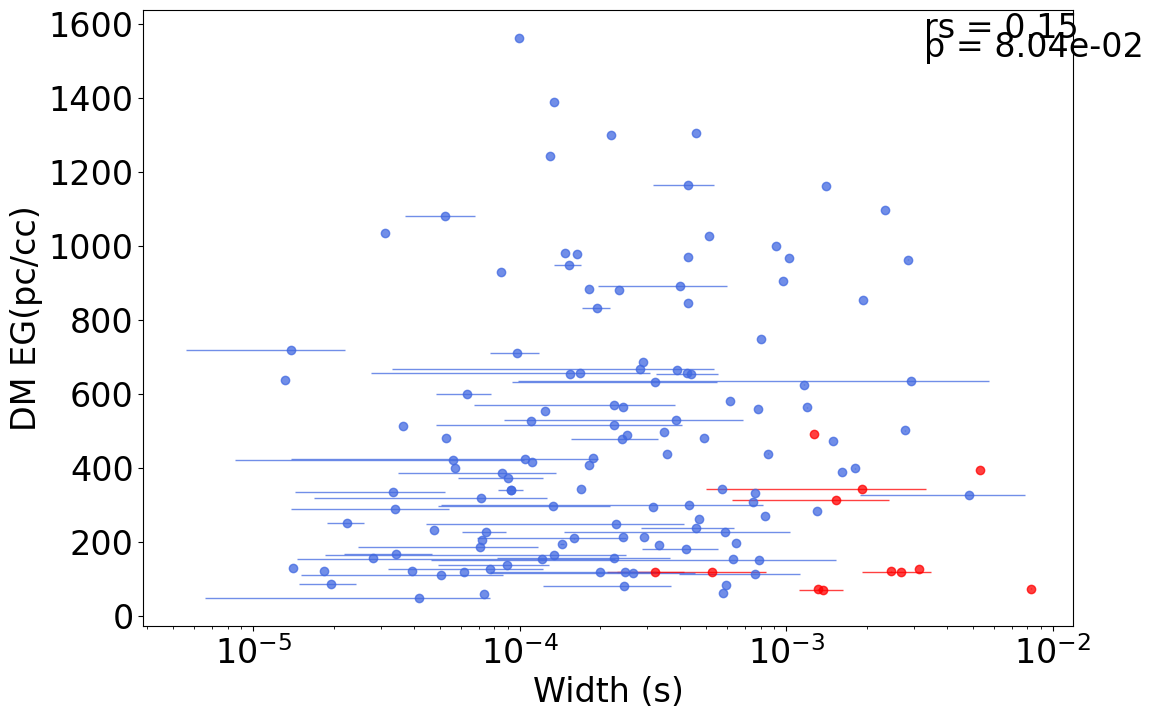

In [25]:
widths_measured_comb = np.concatenate((widths_measured, widths_measured_profile, widths_measured_upper_limits))
widths_measured_comb_max = np.concatenate((widths_measured_max, widths_measured_profile_max, widths_measured_upper_limits_max))

dms_measured_comb = np.concatenate((dms_measured, dms_measured_profile, dms_measured_upper_limits))

widths_err_measured_comb = np.concatenate((width_err_measured, width_err_profile, width_err_upper_limits))
widths_err_measured_comb_max = np.concatenate((width_err_measured_max, width_err_profile_max, width_err_upper_limits_max))

widths_comb_mean = (widths_measured_comb + widths_measured_comb_max)/2

widths_comb_err_low = widths_comb_mean - widths_measured_comb
widths_comb_err_high = widths_measured_comb_max - widths_comb_mean

dms_err_measured_comb = np.concatenate((dm_err_measured, dm_err_profile, dm_err_upper_limits))

tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(widths_comb_mean, dms_measured_comb, widths_comb_err_low, dms_err_measured_comb, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
#plt.yscale('log')
plt.xscale('log')

plt.xlabel("Width (s)")
plt.ylabel("DM EG(pc/cc)")

#### Stats test #####
val, p = scipy.stats.spearmanr(widths_measured_comb, dms_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(widths_measured_comb)-0.005, np.max(dms_measured_comb), 'rs = {}'.format(round(val,3)))
plt.text(np.max(widths_measured_comb)-0.005, np.max(dms_measured_comb)-50, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_full_vs_DM.jpg'
oname1 = 'Paper_plots/Width_full_vs_DM.pdf'

# plt.savefig(oname, dpi=300, bbox_inches='tight')
# plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Width vs Boxcar

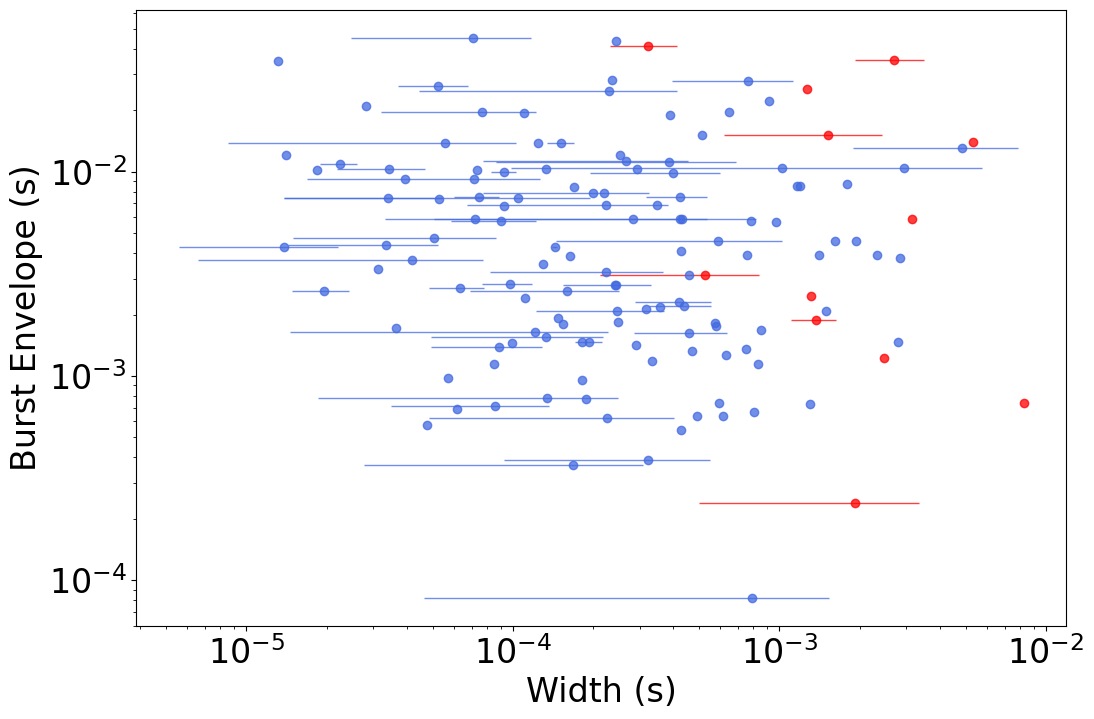

In [27]:

boxcar_base = data_final_basecat['Boxcar_width(s)'].to_numpy().astype(float)  
boxcar_base_err = np.zeros(len(boxcar_base))

tres_color=np.full(len(boxcar_base),'royalblue')
for x, y, xe, ye, color, r in zip(widths_comb_mean, boxcar_base, widths_comb_err_low, boxcar_base_err, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
#plt.yscale('log')
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Width (s)")
plt.ylabel("Burst Envelope (s)")

plt.show()

### Fluence vs Minimum Width ###

-0.11757513
1.71210947e-01


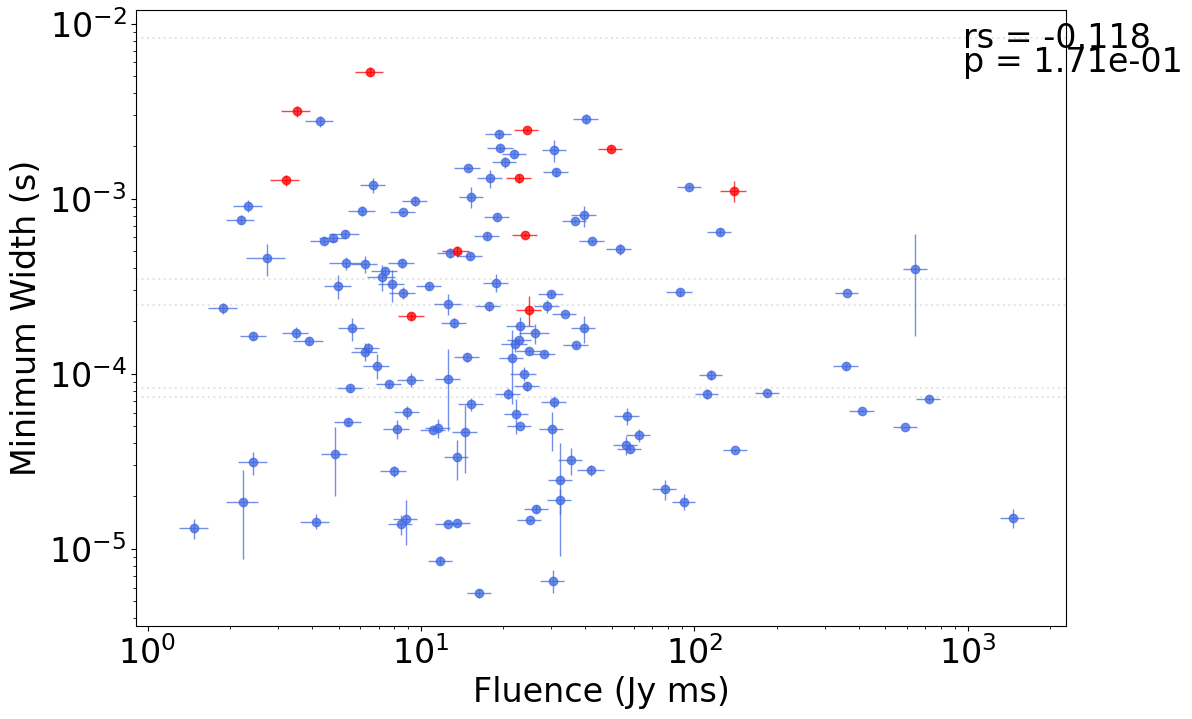

In [28]:
widths_measured_comb = np.concatenate((widths_measured, widths_measured_profile, widths_measured_upper_limits))

fluences_measured_comb = np.concatenate((fluences_measured, fluences_measured_profile, fluences_measured_upper_limits))

widths_err_measured_comb = np.concatenate((width_err_measured, width_err_profile, width_err_upper_limits))

fluences_err_measured_comb = np.concatenate((fluence_err_measured, fluence_err_profile, fluence_err_upper_limits))

tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(fluences_measured_comb, widths_measured_comb, fluences_err_measured_comb, widths_err_measured_comb, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Fluence (Jy ms)")
plt.ylabel("Minimum Width (s)")

#### Stats test #####
val, p = scipy.stats.spearmanr(widths_measured_comb, fluences_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluences_measured_comb)-500, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluences_measured_comb)-500, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_vs_Fluence.jpg'
oname1 = 'Paper_plots/Width_vs_Fluence.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Flux vs Minimum Width ###

-0.56471253
6.59685666e-13


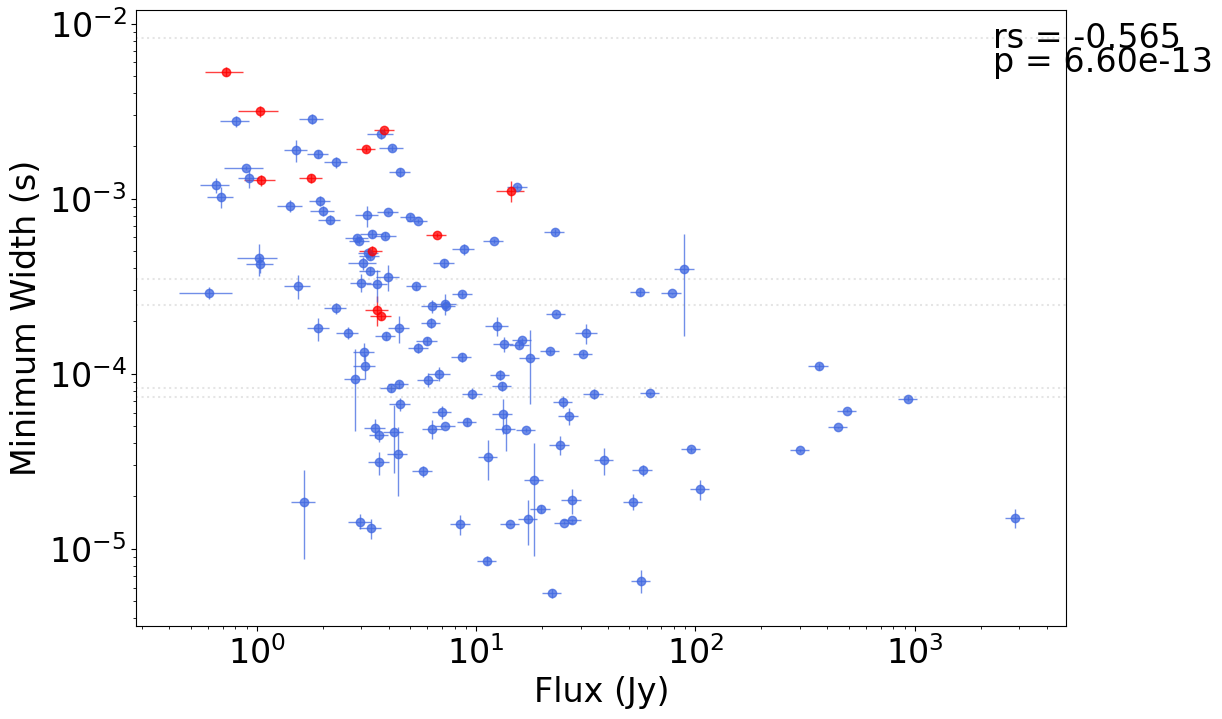

In [29]:
widths_measured_comb = np.concatenate((widths_measured, widths_measured_profile, widths_measured_upper_limits))

fluxes_measured_comb = np.concatenate((fluxes_measured, fluxes_measured_profile, fluxes_measured_upper_limits))

widths_err_measured_comb = np.concatenate((width_err_measured, width_err_profile, width_err_upper_limits))

fluxes_err_measured_comb = np.concatenate((flux_err_measured, flux_err_profile, flux_err_upper_limits))

tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(fluxes_measured_comb, widths_measured_comb, fluxes_err_measured_comb, widths_err_measured_comb, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Flux (Jy)")
plt.ylabel("Minimum Width (s)")

#### Stats test #####
val, p = scipy.stats.spearmanr(widths_measured_comb, fluxes_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_vs_Flux.jpg'
oname1 = 'Paper_plots/Width_vs_Flux.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Flux vs Width ###

-0.51844229
8.63331590e-11


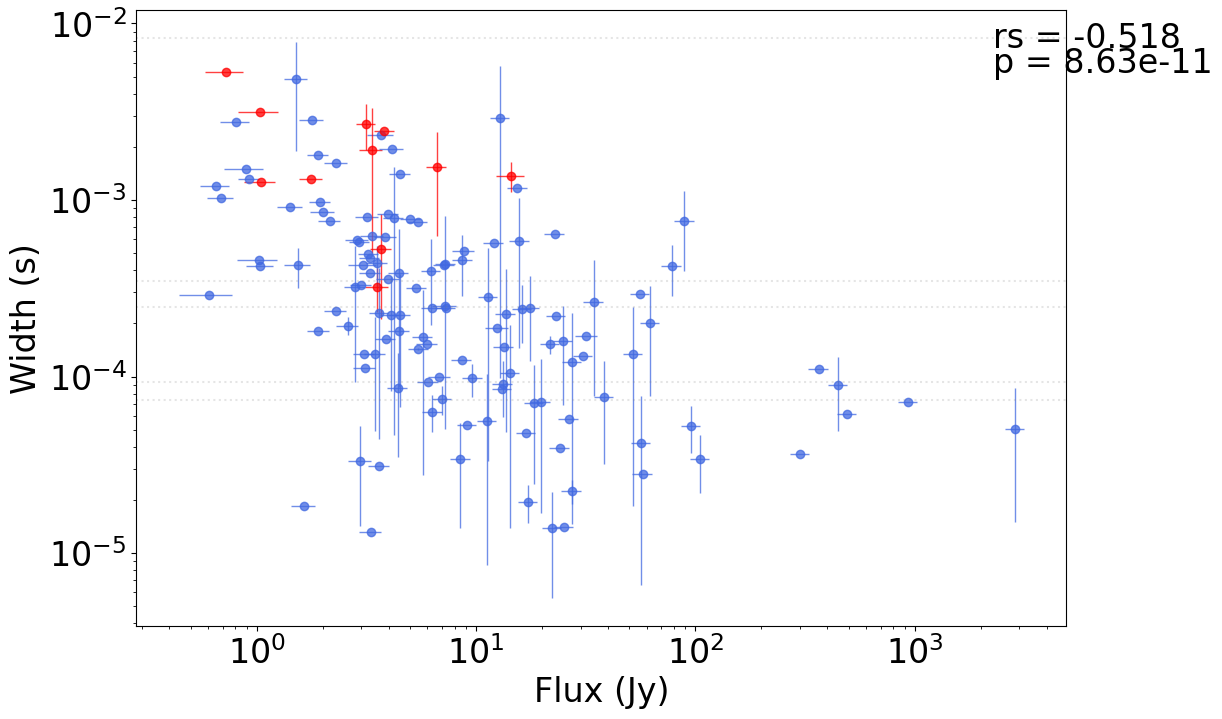

In [30]:
tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(fluxes_measured_comb, widths_comb_mean, fluxes_err_measured_comb, widths_comb_err_low, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Flux (Jy)")
plt.ylabel("Width (s)")

#### Stats test #####
val, p = scipy.stats.spearmanr(widths_comb_mean, fluxes_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_full_vs_Flux.jpg'
oname1 = 'Paper_plots/Width_full_vs_Flux.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Fluence vs Width ###

-0.04441737
6.06285446e-01


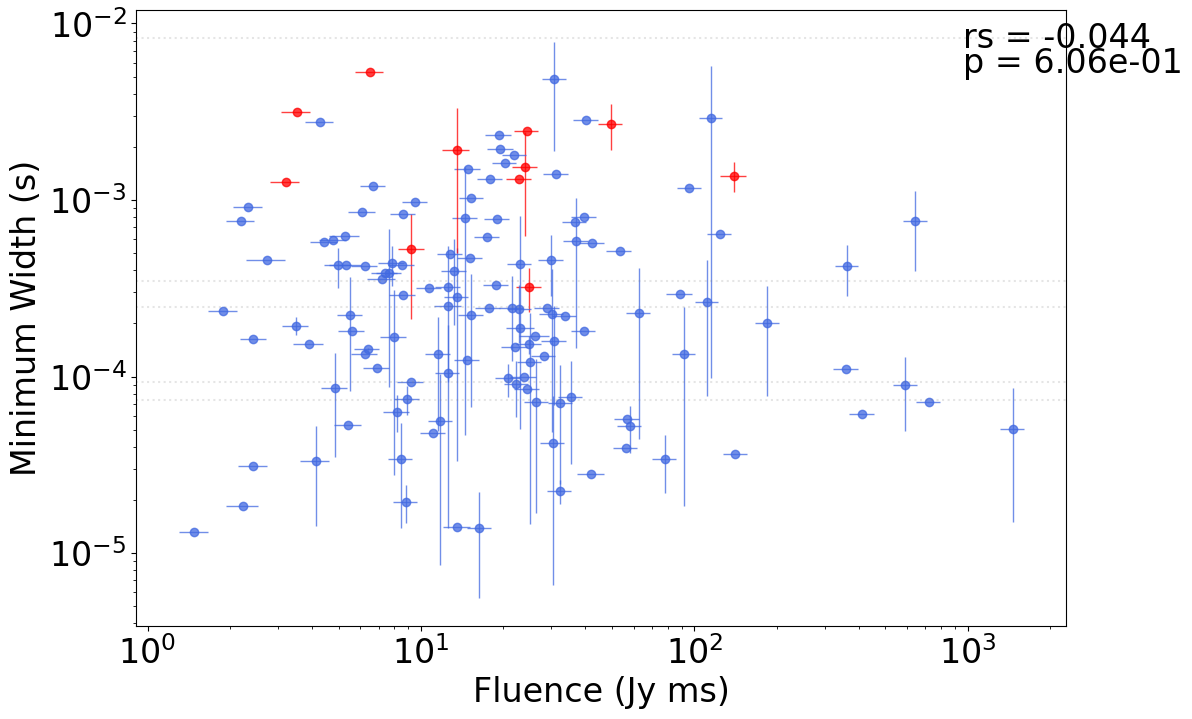

In [31]:
tres_color=np.full(len(dms_measured_comb),'royalblue')
for x, y, xe, ye, color, r in zip(fluences_measured_comb, widths_comb_mean, fluences_err_measured_comb,  widths_comb_err_low, tres_color, repeaters_comb):
    if x > 0 and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif x > 0 and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    else:
        plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
        
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Fluence (Jy ms)")
plt.ylabel("Minimum Width (s)")

#### Stats test #####
val, p = scipy.stats.spearmanr(widths_comb_mean, fluences_measured_comb)
print(round(val,8))
print("{:.8e}".format(p))

plt.text(np.max(fluences_measured_comb)-500, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
plt.text(np.max(fluences_measured_comb)-500, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_full_vs_Fluence.jpg'
oname1 = 'Paper_plots/Width_full_vs_Fluence.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Bandwidth vs Width ###

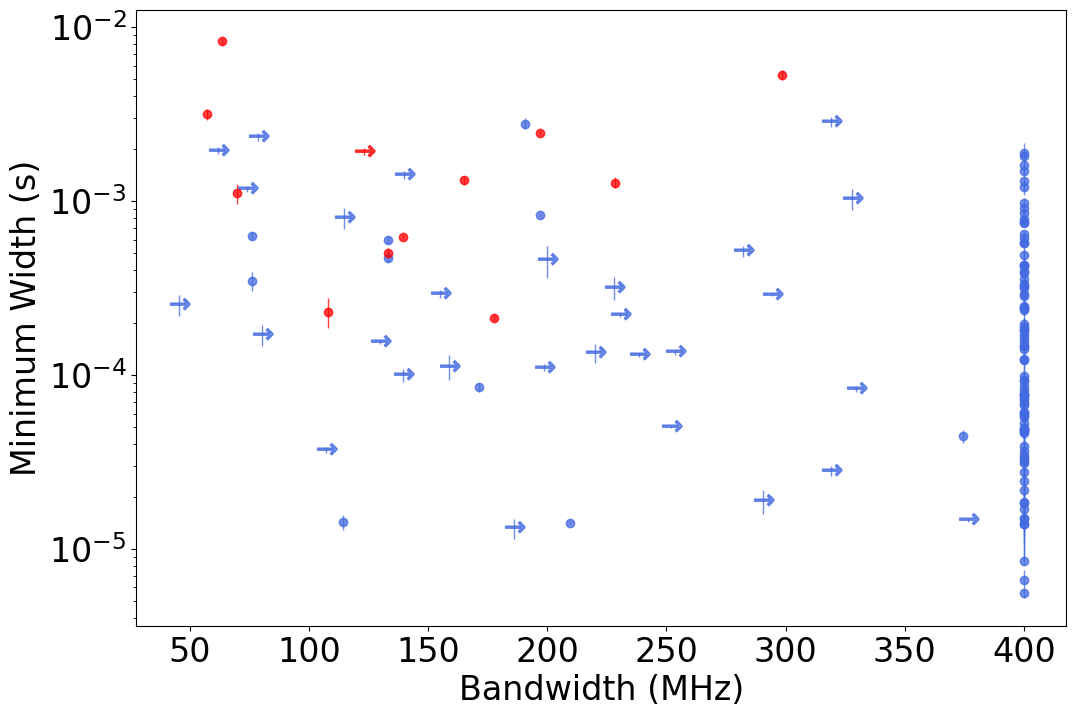

In [32]:
##### Add histograms on the side and top here ######

bw_measured = data_only_scat_final['Bandwidth'].to_numpy()
top_avail_measured = data_only_scat_final['Top_avail_freq'].to_numpy()
#flux_err_measured = data_only_scat_final['Flux_err(Jy)'].to_numpy()

bw_measured_upper_limits = data_no_scat_final['Bandwidth'].to_numpy()
top_avail_upper_limits = data_no_scat_final['Top_avail_freq'].to_numpy()

#flux_err_upper_limits = data_no_scat_final['Flux_err(Jy)'].to_numpy()

bw_measured_profile = data_final_basecat_only_profile['Bandwidth'].to_numpy()
top_avail_profile = data_final_basecat_only_profile['Top_avail_freq'].to_numpy()
#flux_err_profile = data_final_basecat_only_profile['Flux_err(Jy)'].to_numpy()


bw_measured_comb = np.concatenate((bw_measured, bw_measured_profile, bw_measured_upper_limits))
top_measured_comb = np.concatenate((top_avail_measured, top_avail_profile, top_avail_upper_limits))
bw_err_comb = np.zeros(len(bw_measured_comb))

tres_color=np.full(len(bw_measured_comb),'royalblue')
for x, y, xe, ye, color, top, r in zip(bw_measured_comb, widths_measured_comb, bw_err_comb, widths_err_measured_comb, tres_color, top_measured_comb, repeaters_comb):
    if top == FREQ_TOP_MHZ and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif top == FREQ_TOP_MHZ and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    elif top < FREQ_TOP_MHZ and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
    elif top < FREQ_TOP_MHZ and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
        
plt.yscale('log')
#plt.xscale('log')

plt.xlabel("Bandwidth (MHz)")
plt.ylabel("Minimum Width (s)")

#### Stats test #####
# val, p = scipy.stats.spearmanr(widths_measured_comb, fluxes_measured_comb)
# print(round(val,8))
# print("{:.8e}".format(p))

# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_vs_Bandwidth.jpg'
oname1 = 'Paper_plots/Width_vs_Bandwidth.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Bandwidth vs Width Hist

/tmp/ipykernel_3097/3036950841.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_histx.set_yticklabels(labs_y)
/tmp/ipykernel_3097/3036950841.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_histy.set_xticklabels(labs_x)


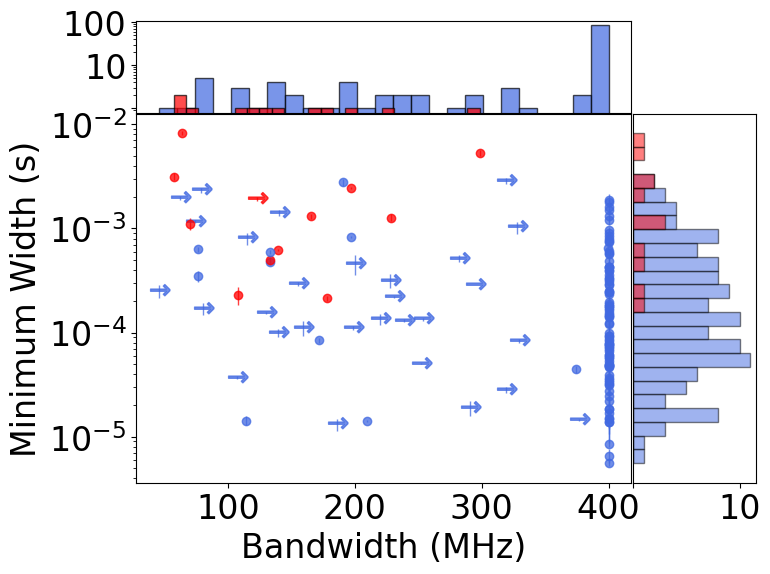

In [42]:
##### Add histograms on the side and top here ######

# bw_measured = data_only_scat_final['Bandwidth'].to_numpy()
# top_avail_measured = data_only_scat_final['Top_avail_freq'].to_numpy()
# #flux_err_measured = data_only_scat_final['Flux_err(Jy)'].to_numpy()

# bw_measured_upper_limits = data_no_scat_final['Bandwidth'].to_numpy()
# top_avail_upper_limits = data_no_scat_final['Top_avail_freq'].to_numpy()

# #flux_err_upper_limits = data_no_scat_final['Flux_err(Jy)'].to_numpy()

# bw_measured_profile = data_final_basecat_only_profile['Bandwidth'].to_numpy()
# top_avail_profile = data_final_basecat_only_profile['Top_avail_freq'].to_numpy()
# #flux_err_profile = data_final_basecat_only_profile['Flux_err(Jy)'].to_numpy()


# bw_measured_comb = np.concatenate((bw_measured, bw_measured_profile, bw_measured_upper_limits))
# top_measured_comb = np.concatenate((top_avail_measured, top_avail_profile, top_avail_upper_limits))
# bw_err_comb = np.zeros(len(bw_measured_comb))


repeaters_comb = data_final_basecat['Repeater'].to_numpy()
bw_measured_comb = data_final_basecat['Bandwidth'].to_numpy()
bw_err_comb = np.zeros(len(bw_measured_comb))
top_measured_comb = data_final_basecat['Top_avail_freq'].to_numpy()
widths_measured_comb = data_final_basecat['Min_width(s)'].to_numpy()
widths_err_measured_comb = data_final_basecat['Min_width_err(s)'].to_numpy()

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(3, 3, width_ratios=[3, 1, 1], height_ratios=[1, 3, 1])

# Scatter plot with error bars
ax_scatter = fig.add_subplot(gs[1:, :-1])

bw_non_repeat = []
bw_repeat = []
width_non_repeat = []
width_repeat = []

tres_color=np.full(len(bw_measured_comb),'royalblue')
for x, y, xe, ye, color, top, r in zip(bw_measured_comb, widths_measured_comb, bw_err_comb, widths_err_measured_comb, tres_color, top_measured_comb, repeaters_comb):
    if top == FREQ_TOP_MHZ and not r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
        bw_non_repeat.append(x)
        width_non_repeat.append(y)
    elif top == FREQ_TOP_MHZ and r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
        bw_repeat.append(x)
        width_repeat.append(y)
    elif top < FREQ_TOP_MHZ and not r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
        bw_non_repeat.append(x)
        width_non_repeat.append(y)
    elif top < FREQ_TOP_MHZ and r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
        bw_repeat.append(x)
        width_repeat.append(y)
        
ax_scatter.set_yscale('log')
#plt.xscale('log')

ax_scatter.set_xlabel("Bandwidth (MHz)")
ax_scatter.set_ylabel("Minimum Width (s)")

ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)

# Plot histograms
bins = 25

ax_histx.hist(bw_non_repeat, bins=bins, color='royalblue', alpha=0.7, orientation='vertical', edgecolor='k')
ax_histx.hist(bw_repeat, bins=bins, color='r', alpha=0.7, orientation='vertical', edgecolor='k', zorder=11)
ax_histx.set_yscale('log')

hist, bins_w = np.histogram(widths_measured_comb, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)
# ax_histy.set_xscale('log')
ax_histy.hist(width_non_repeat, bins=logbins, color='royalblue', alpha=0.5, orientation='horizontal', edgecolor='k')
ax_histy.hist(width_repeat, bins=logbins, color='r', alpha=0.5, orientation='horizontal', edgecolor='k', zorder=11)

ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop = False)
labs_y = ax_histx.get_yticks().tolist()
labs_y = ['','','',10,100,'']
ax_histx.set_yticklabels(labs_y)

ax_histy.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False, labeltop = False, left = False, right=False, labelleft=False)
labs_x = ax_histy.get_xticks().tolist()
labs_x = ['',10,20]
ax_histy.set_xticklabels(labs_x)



# Adjust layout
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Save or show the plot


#### Stats test #####
# val, p = scipy.stats.spearmanr(widths_measured_comb, fluxes_measured_comb)
# print(round(val,8))
# print("{:.8e}".format(p))

# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Width_vs_Bandwidth_hist.jpg'
oname1 = 'Paper_plots/Width_vs_Bandwidth_hist.pdf'

# plt.savefig(oname, dpi=300, bbox_inches='tight')
# plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

### Burst Duration vs Bandwidthto_numpy

22154974 400.0 0.000576 800.1953125
22310619 400.0 0.00268288 800.1953125
22457855 400.0 0.00688128 800.1953125
22574084 400.0 0.00063488 800.1953125
23070533 400.0 0.01015808 800.1953125
23232723 400.0 0.0013311999999999998 800.1953125
23438043 133.33333333333337 0.007864320000000001 800.1953125
23526901 400.0 0.04112384 800.1953125
23613379 400.0 0.00311296 800.1953125
23723094 400.0 0.00743424 800.1953125
23907110 400.0 0.00095744 800.1953125
24114218 76.1904761904762 0.00917504 800.1953125
24194876 400.0 0.01212416 800.1953125
24365582 400.0 0.00211968 800.1953125
24512726 400.0 0.00352256 800.1953125
25677682 76.1904761904762 0.00458752 800.1953125
26690059 400.0 0.00589824 800.1953125
27112562 400.0 0.00181248 800.1953125
27618689 400.0 0.01032192 800.1953125
27687783 400.0 0.027750399999999998 800.1953125
28012492 400.0 0.02097152 800.1953125
28129879 400.0 0.0027852800000000002 800.1953125
28783556 171.42857142857144 0.00376832 800.1953125
28845693 400.0 0.00063488 800.1953125


/tmp/ipykernel_3097/1297576455.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_histx.set_yticklabels(labs_y)
/tmp/ipykernel_3097/1297576455.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_histy.set_xticklabels(labs_x)


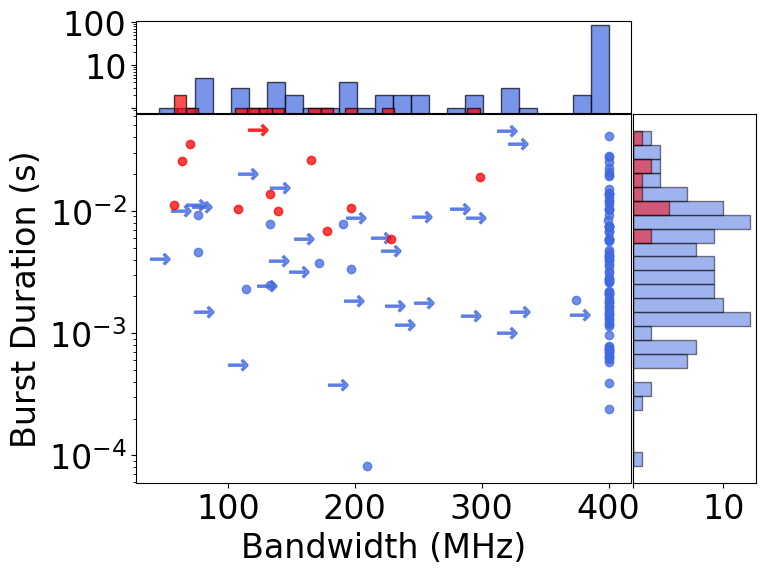

In [56]:
##### Add histograms on the side and top here ######

# bw_measured = data_only_scat_final['Bandwidth'].to_numpy()
# top_avail_measured = data_only_scat_final['Top_avail_freq'].to_numpy()
# #flux_err_measured = data_only_scat_final['Flux_err(Jy)'].to_numpy()

# bw_measured_upper_limits = data_no_scat_final['Bandwidth'].to_numpy()
# top_avail_upper_limits = data_no_scat_final['Top_avail_freq'].to_numpy()

# #flux_err_upper_limits = data_no_scat_final['Flux_err(Jy)'].to_numpy()

# bw_measured_profile = data_final_basecat_only_profile['Bandwidth'].to_numpy()
# top_avail_profile = data_final_basecat_only_profile['Top_avail_freq'].to_numpy()
# #flux_err_profile = data_final_basecat_only_profile['Flux_err(Jy)'].to_numpy()


# bw_measured_comb = np.concatenate((bw_measured, bw_measured_profile, bw_measured_upper_limits))
# top_measured_comb = np.concatenate((top_avail_measured, top_avail_profile, top_avail_upper_limits))
# bw_err_comb = np.zeros(len(bw_measured_comb))

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(3, 3, width_ratios=[3, 1, 1], height_ratios=[1, 3, 1])

# Scatter plot with error bars
ax_scatter = fig.add_subplot(gs[1:, :-1])

bw_non_repeat = []
bw_repeat = []
width_non_repeat = []
width_repeat = []

repeaters_comb = data_final_basecat['Repeater'].to_numpy()
bw_measured_comb = data_final_basecat['Bandwidth'].to_numpy()
bw_err_comb = np.zeros(len(bw_measured_comb))
top_measured_comb = data_final_basecat['Top_avail_freq'].to_numpy()
events_comb = data_final_basecat['Event'].to_numpy()

# for i in range(len(repeaters_comb)):
#     print(events[i], boxcar_base[i], repeaters_comb[i], bw_measured_comb[i], )

tres_color=np.full(len(bw_measured_comb),'royalblue')
for x, y, xe, ye, color, top, r, e in zip(bw_measured_comb, boxcar_base, bw_err_comb, boxcar_base_err, tres_color, top_measured_comb, repeaters_comb, events_comb):
    if top == FREQ_TOP_MHZ and not r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
        bw_non_repeat.append(x)
        width_non_repeat.append(y)
        print(e, x, y, top)
    elif top == FREQ_TOP_MHZ and r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
        bw_repeat.append(x)
        width_repeat.append(y)
    elif top < FREQ_TOP_MHZ and not r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
        bw_non_repeat.append(x)
        width_non_repeat.append(y)
    elif top < FREQ_TOP_MHZ and r:
        ax_scatter.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
        bw_repeat.append(x)
        width_repeat.append(y)
        
ax_scatter.set_yscale('log')
#plt.xscale('log')

ax_scatter.set_xlabel("Bandwidth (MHz)")
ax_scatter.set_ylabel("Burst Duration (s)")

ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)

# Plot histograms
bins = 25

ax_histx.hist(bw_non_repeat, bins=bins, color='royalblue', alpha=0.7, orientation='vertical', edgecolor='k')
ax_histx.hist(bw_repeat, bins=bins, color='r', alpha=0.7, orientation='vertical', edgecolor='k', zorder=11)
ax_histx.set_yscale('log')

hist, bins_w = np.histogram(boxcar_base, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)
# ax_histy.set_xscale('log')
ax_histy.hist(width_non_repeat, bins=logbins, color='royalblue', alpha=0.5, orientation='horizontal', edgecolor='k')
ax_histy.hist(width_repeat, bins=logbins, color='r', alpha=0.5, orientation='horizontal', edgecolor='k', zorder=11)

ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop = False)
labs_y = ax_histx.get_yticks().tolist()
labs_y = ['','','',10,100,'']
ax_histx.set_yticklabels(labs_y)

ax_histy.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False, labeltop = False, left = False, right=False, labelleft=False)
labs_x = ax_histy.get_xticks().tolist()
labs_x = ['',10,20]
ax_histy.set_xticklabels(labs_x)



# Adjust layout
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Save or show the plot


#### Stats test #####
# val, p = scipy.stats.spearmanr(widths_measured_comb, fluxes_measured_comb)
# print(round(val,8))
# print("{:.8e}".format(p))

# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Duration_vs_Bandwidth_hist.jpg'
oname1 = 'Paper_plots/Duration_vs_Bandwidth_hist.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

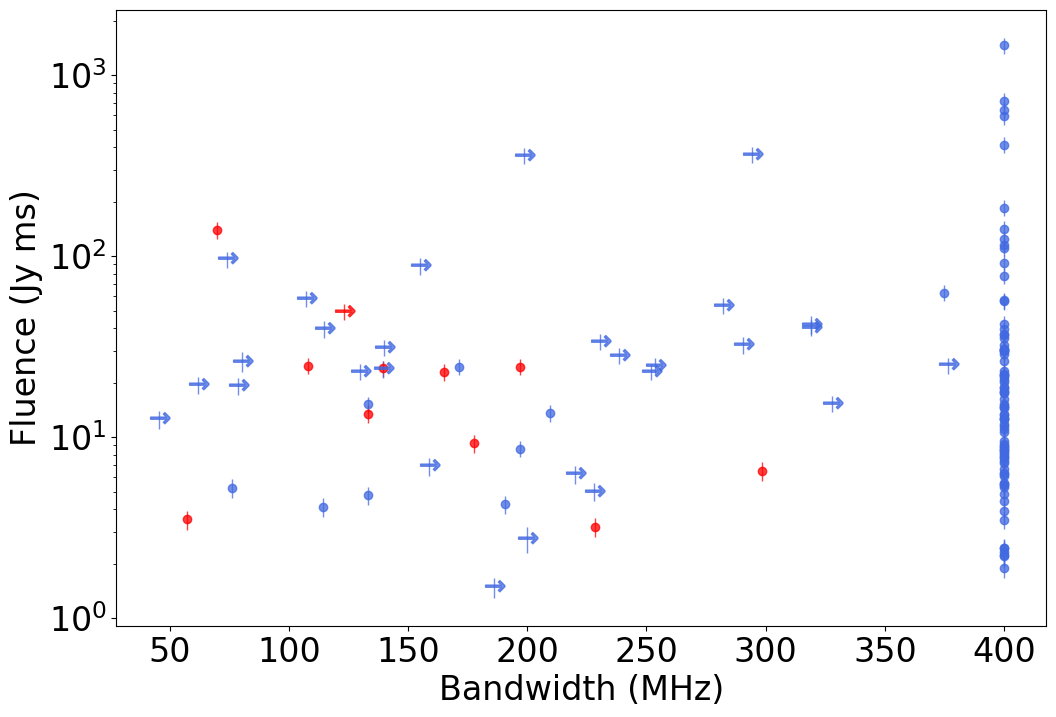

In [33]:
bw_measured = data_only_scat_final['Bandwidth'].to_numpy()
#flux_err_measured = data_only_scat_final['Flux_err(Jy)'].to_numpy()

bw_measured_upper_limits = data_no_scat_final['Bandwidth'].to_numpy()
#flux_err_upper_limits = data_no_scat_final['Flux_err(Jy)'].to_numpy()

bw_measured_profile = data_final_basecat_only_profile['Bandwidth'].to_numpy()
#flux_err_profile = data_final_basecat_only_profile['Flux_err(Jy)'].to_numpy()


bw_measured_comb = np.concatenate((bw_measured, bw_measured_profile, bw_measured_upper_limits))
bw_err_comb = np.zeros(len(bw_measured_comb))

tres_color=np.full(len(bw_measured_comb),'royalblue')
for x, y, xe, ye, color, top, r in zip(bw_measured_comb, fluences_measured_comb, bw_err_comb, fluences_err_measured_comb, tres_color, top_measured_comb, repeaters_comb):
    # if x > 0:
    #     plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    # else:
    #     plt.axhline(y, linestyle=':', c='gray', alpha=0.2)
        
    if top == FREQ_TOP_MHZ and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')
    elif top == FREQ_TOP_MHZ and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = 'o')
    elif top < FREQ_TOP_MHZ and not r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color=color, zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
    elif top < FREQ_TOP_MHZ and r:
        plt.errorbar(x, y, xerr=xe, yerr=ye, lw=1, color='r', zorder=1, alpha=0.75, marker = r'$\rightarrow$', markersize=15)
    else:
        plt.axvline(x, linestyle=':', c='gray', alpha=0.2)
        
plt.yscale('log')
#plt.xscale('log')

plt.xlabel("Bandwidth (MHz)")
plt.ylabel("Fluence (Jy ms)")

#### Stats test #####
# val, p = scipy.stats.spearmanr(widths_measured_comb, fluxes_measured_comb)
# print(round(val,8))
# print("{:.8e}".format(p))

# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.001, 'rs = {}'.format(round(val,3)))
# plt.text(np.max(fluxes_measured_comb)-600, np.max(widths_measured_comb)-0.003, "p = {:.2e}".format(p))

oname = 'Paper_plots/Fluence_vs_bandwidth.jpg'
oname1 = 'Paper_plots/FLuence_vs_bandwidth.pdf'

plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.savefig(oname1, dpi=300, bbox_inches='tight')

plt.show()

[1.09229059e+40 7.57548510e+40 1.24087946e+41 1.49731245e+41
 6.52407773e+39 1.20349312e+42 3.11375749e+40 1.50415071e+39
 9.21002995e+38 1.37716839e+40 2.80720146e+40 1.33386950e+41
 8.55377405e+40 1.30480112e+40 8.10516714e+39 1.81604222e+41
 1.83730062e+40 5.14979799e+41 2.75025908e+40 9.29786325e+41
 1.66030934e+40 1.79524663e+41 6.85639370e+40 6.64460558e+40
 2.84083582e+41 5.41285624e+41 8.77853427e+40 1.02480325e+41
 2.50623705e+41 1.31301332e+41 1.34516049e+40 3.95593582e+40
 9.51112505e+41 6.91308194e+40 7.21295502e+40 1.44509362e+41
 2.92870671e+40 2.56019066e+40 2.34542438e+40 1.99931578e+41
 1.05429550e+40 2.66117274e+40 1.42330605e+40 3.74440037e+41
 8.32783442e+39 1.30789591e+42 1.20680625e+42 1.99301771e+40
 1.80679525e+41 7.64372592e+40 4.49978150e+41 2.17968052e+40
 2.91484496e+41 1.49237864e+41 5.41109083e+40 6.57130583e+40
 7.38412397e+39 9.33343379e+40 1.20407467e+40 5.13631635e+38
 4.45690448e+40 3.44439124e+40 2.38640274e+40 2.71668185e+39
 9.38311371e+40 7.139635

Text(0, 0.5, 'Count')

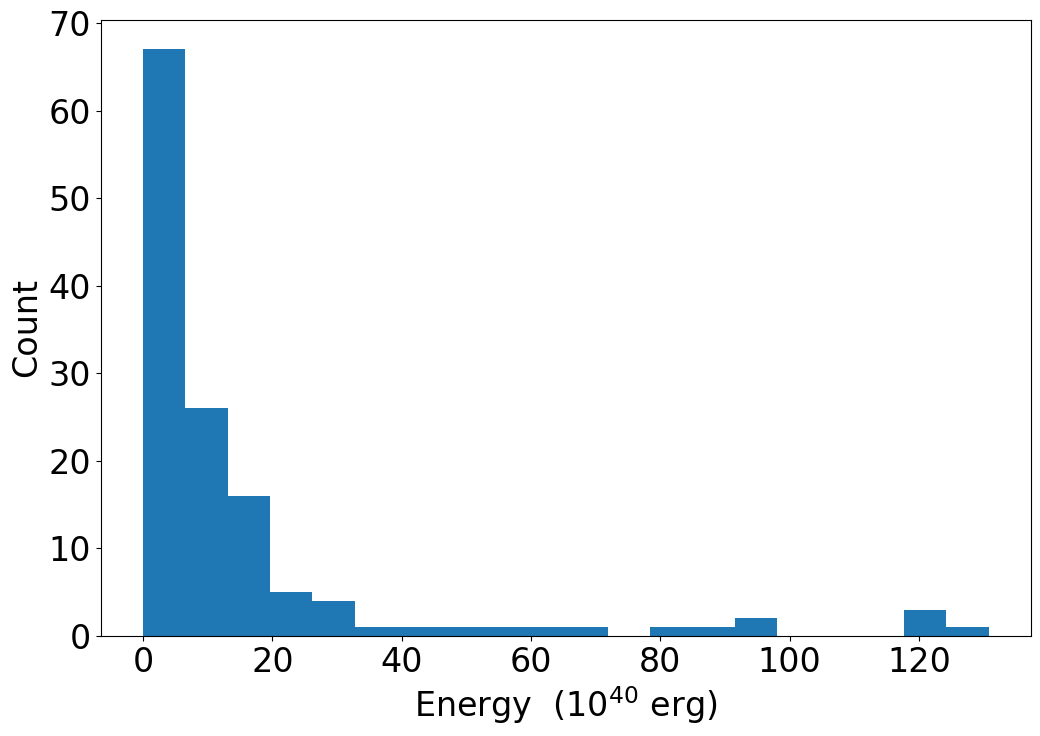

In [34]:
energies_comb = get_energy(dms_measured_comb, fluences_measured_comb, bw_measured_comb)
idx = np.where(energies_comb == 0)[0]
energies_comb_del = np.delete(energies_comb, idx)
print(energies_comb_del)
bins = 20
plt.hist(energies_comb_del/1e40, bins=bins)
plt.xlabel(r'Energy  ($10^{40}$ erg)')
plt.ylabel('Count')

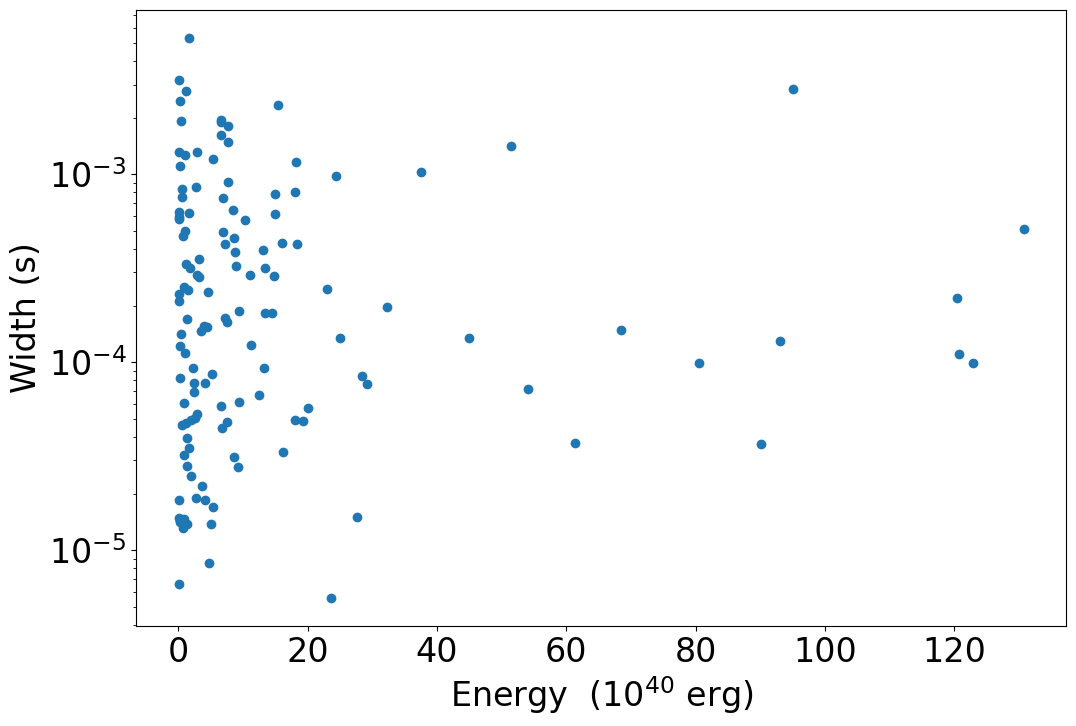

In [35]:
width_comb_del = np.delete(widths_measured_comb, idx)
plt.scatter(energies_comb_del/1e40, width_comb_del)
plt.xlabel(r'Energy  ($10^{40}$ erg)')
plt.ylabel('Width (s)')
plt.yscale('log')

In [149]:
##### Plot the depolarization vs scattering one #####
##### Plot the bandwidth maybe the peak frequency with flux or something #####

''' Your Code Here '''

' Your Code Here '